## Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from apyori import apriori

import datetime

import statsmodels.api as sm

from scipy.stats import spearmanr 

from sklearn.impute import SimpleImputer

from scipy.spatial.distance import cdist 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.feature_selection import RFECV

import joblib

from math import radians, cos, sin, asin, sqrt

# Preprocessing

In [34]:
dataframe = pd.read_csv('dataset.csv')
dataframe

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,Wash_Item,Washer_No,Dryer_No,Spectacles,TimeSpent_minutes,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets
0,19/10/2015,20:17:50,malay,male,moderate,28.0,yes,young,big,red,...,clothes,3,10,no,20.0,2.0,9.0,2.912316,101.657948,1.0
1,19/10/2015,20:28:42,NaN,male,thin,32.0,no,no_kids,big,NaN,...,NaN,6,9,no,19.0,4.0,21.0,2.922506,101.643129,3.0
2,19/10/2015,20:58:31,malay,female,moderate,30.0,no,no_kids,big,blue,...,NaN,4,10,no,18.0,2.0,13.0,2.935533,101.737170,1.0
3,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,...,clothes,5,9,no,13.0,2.0,16.0,2.949924,101.637069,1.0
4,19/10/2015,21:40:28,indian,male,NaN,34.0,no,no_kids,big,blue,...,clothes,3,9,NaN,15.0,1.0,13.0,2.903530,101.661249,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,24/01/2016,21:45:06,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,blankets,6,7,yes,15.0,3.0,9.0,3.082212,101.644878,2.0
3996,26/12/2015,1:48:15,malay,male,moderate,24.0,yes,baby,small,green,...,clothes,4,10,yes,53.0,3.0,13.0,3.118138,101.677315,3.0
3997,07/12/2015,1:42:32,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,clothes,4,9,no,56.0,2.0,7.0,3.101051,101.643060,1.0
3998,10/02/2016,0:24:23,indian,female,thin,18.0,yes,baby,big,black,...,blankets,6,10,no,26.0,2.0,7.0,3.136530,101.699091,1.0


In [35]:
dataframe.isnull().sum()

Date                   0
Time                   0
Race                 198
Gender               177
Body_Size            183
Age_Range            143
With_Kids            186
Kids_Category         30
Basket_Size          205
Basket_colour        203
Attire               217
Shirt_Colour         174
shirt_type           185
Pants_Colour         174
pants_type             9
Wash_Item            181
Washer_No              0
Dryer_No               0
Spectacles           209
TimeSpent_minutes     69
buyDrinks             35
TotalSpent_RM         54
latitude               0
longitude              0
Num_of_Baskets       182
dtype: int64

# Inbalance Plot

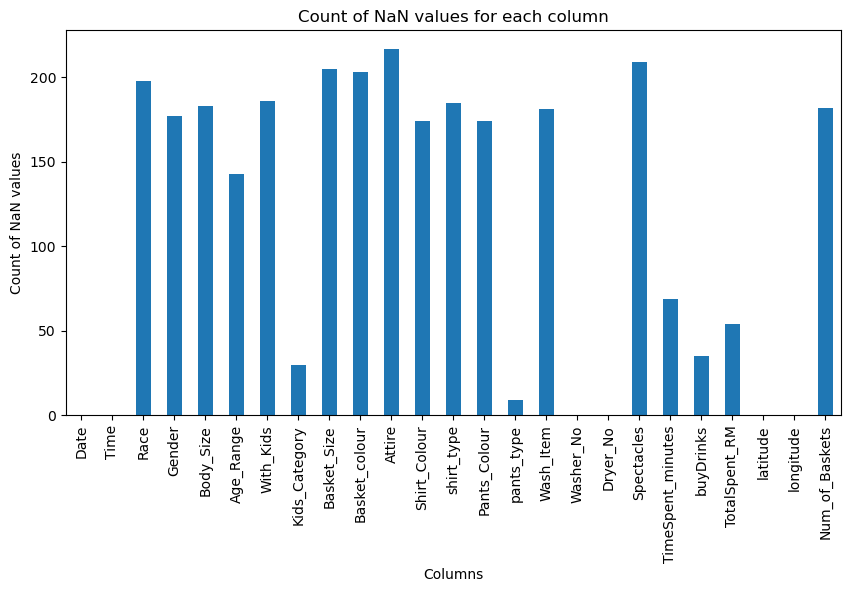

In [45]:
# plot nan values count for each column
dataframe.isnull().sum().plot(kind='bar', figsize=(10, 5))
plt.title('Count of NaN values for each column')
plt.xlabel('Columns')
plt.ylabel('Count of NaN values')
plt.show()

## Association Rule Mining

In [10]:
df = dataframe[[
  "Gender",
  "With_Kids",
  "Basket_Size",
  "Attire",
  "Wash_Item",
  "shirt_type",
]]

df

,Gender,With_Kids,Basket_Size,Attire,Wash_Item,shirt_type
0,male,yes,big,casual,clothes,short_sleeve
1,male,no,big,casual,NaN,short_sleeve
2,female,no,big,casual,NaN,short_sleeve
3,male,no,NaN,casual,clothes,short_sleeve
4,male,no,big,casual,clothes,NaN
...,...,...,...,...,...,...
3995,male,yes,small,traditional,blankets,short_sleeve
3996,male,yes,small,formal,clothes,long sleeve
3997,male,yes,small,casual,clothes,long sleeve
3998,female,yes,big,traditional,blankets,short_sleeve


In [11]:
col_list = df.columns
df_oh = df[col_list]
df = df.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df = pd.concat([df, df_oh], axis=1)
df.shape

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_10612/2005124313.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(col_list, 1)


(4000, 13)

In [12]:
records = []
for i in range(0, 4000):
    records.append([str(df.columns[j]) for j in range(0, 13) if df.values[i,j] == 1])
    
records[0]

['Gender_male',
 'With_Kids_yes',
 'Basket_Size_big',
 'Attire_casual',
 'Wash_Item_clothes',
 'shirt_type_short_sleeve']

In [13]:
association_results = apriori(records)
association_results = list(association_results)
len(association_results)

138

In [14]:
cnt = 0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0]
    items = [x for x in pair]
    if len(items) < 2:
        print("(Rule " + str(cnt) + ") " + items[0])
    else:
        print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])
    
    # second index of the inner list
    print("Support: " + str(round(item[1],3)))
    
    # third index of the list located at 0th
    # of the third index of the inner list 
    
    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) Attire_casual
Support: 0.383
Confidence: 0.3827
Lift: 1.0
(Rule 2) Attire_formal
Support: 0.294
Confidence: 0.2943
Lift: 1.0
(Rule 3) Attire_traditional
Support: 0.269
Confidence: 0.2687
Lift: 1.0
(Rule 4) Basket_Size_big
Support: 0.549
Confidence: 0.5493
Lift: 1.0
(Rule 5) Basket_Size_small
Support: 0.4
Confidence: 0.3995
Lift: 1.0
(Rule 6) Gender_female
Support: 0.483
Confidence: 0.4828
Lift: 1.0
(Rule 7) Gender_male
Support: 0.473
Confidence: 0.473
Lift: 1.0
(Rule 8) Wash_Item_blankets
Support: 0.415
Confidence: 0.4153
Lift: 1.0
(Rule 9) Wash_Item_clothes
Support: 0.539
Confidence: 0.5395
Lift: 1.0
(Rule 10) With_Kids_no
Support: 0.527
Confidence: 0.5272
Lift: 1.0
(Rule 11) With_Kids_yes
Support: 0.426
Confidence: 0.4263
Lift: 1.0
(Rule 12) shirt_type_long sleeve
Support: 0.427
Confidence: 0.4273
Lift: 1.0
(Rule 13) shirt_type_short_sleeve
Support: 0.526
Confidence: 0.5265
Lift: 1.0
(Rule 14) Basket_Size_big -> Attire_casual
Support: 0.228
Confidence: 0.2275
Lift: 1.0
(Rule

## Explanatory Data Analysis

### Preprocessing

In [15]:
p_df = dataframe.copy()

print(p_df.isnull().sum())
len(p_df)

Date                   0
Time                   0
Race                 198
Gender               177
Body_Size            183
Age_Range            143
With_Kids            186
Kids_Category         30
Basket_Size          205
Basket_colour        203
Attire               217
Shirt_Colour         174
shirt_type           185
Pants_Colour         174
pants_type             9
Wash_Item            181
Washer_No              0
Dryer_No               0
Spectacles           209
TimeSpent_minutes     69
buyDrinks             35
TotalSpent_RM         54
latitude               0
longitude              0
Num_of_Baskets       182
dtype: int64


4000

In [112]:
p_df = p_df.dropna(subset=['Race', 'Gender', 'latitude', 'longitude'], inplace=False)
p_df['Body_Size'].fillna('moderate', inplace=True)
p_df['Age_Range'].fillna(p_df['Age_Range'].mean(), inplace=True)
p_df["With_Kids"].fillna("no", inplace=True)
p_df['Kids_Category'].fillna('no_kids', inplace=True)
p_df['Basket_Size'].fillna('small', inplace=True)
p_df['TimeSpent_minutes'].fillna(p_df['TimeSpent_minutes'].mean(), inplace=True)
p_df['buyDrinks'].fillna(0.0, inplace=True)
p_df['TotalSpent_RM'].fillna(0.0, inplace=True)

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputed_data = imp.fit_transform(p_df)

imp_df = pd.DataFrame(imputed_data, columns = p_df.columns)

display(imp_df)
imp_df.isnull().sum()

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,Wash_Item,Washer_No,Dryer_No,Spectacles,TimeSpent_minutes,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets
0,19/10/2015,20:17:50,malay,male,moderate,28.0,yes,young,big,red,...,clothes,3,10,no,20.0,2.0,9.0,2.912316,101.657948,1.0
1,19/10/2015,20:58:31,malay,female,moderate,30.0,no,no_kids,big,blue,...,clothes,4,10,no,18.0,2.0,13.0,2.935533,101.73717,1.0
2,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,small,black,...,clothes,5,9,no,13.0,2.0,16.0,2.949924,101.637069,1.0
3,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,...,clothes,3,9,no,15.0,1.0,13.0,2.90353,101.661249,3.0
4,20/10/2015,0:24:01,indian,male,thin,49.0,no,no_kids,big,blue,...,clothes,3,9,no,46.0,0.0,16.0,2.951176,101.746526,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,24/01/2016,21:45:06,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,blankets,6,7,yes,15.0,3.0,9.0,3.082212,101.644878,2.0
3644,26/12/2015,1:48:15,malay,male,moderate,24.0,yes,baby,small,green,...,clothes,4,10,yes,53.0,3.0,13.0,3.118138,101.677315,3.0
3645,07/12/2015,1:42:32,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,clothes,4,9,no,56.0,2.0,7.0,3.101051,101.64306,1.0
3646,10/02/2016,0:24:23,indian,female,thin,18.0,yes,baby,big,black,...,blankets,6,10,no,26.0,2.0,7.0,3.13653,101.699091,1.0


Date                 0
Time                 0
Race                 0
Gender               0
Body_Size            0
Age_Range            0
With_Kids            0
Kids_Category        0
Basket_Size          0
Basket_colour        0
Attire               0
Shirt_Colour         0
shirt_type           0
Pants_Colour         0
pants_type           0
Wash_Item            0
Washer_No            0
Dryer_No             0
Spectacles           0
TimeSpent_minutes    0
buyDrinks            0
TotalSpent_RM        0
latitude             0
longitude            0
Num_of_Baskets       0
dtype: int64

In [113]:
weather_data = pd.read_csv('./weather.csv')
weather_data = weather_data.drop(['Unnamed: 0'], axis=1)
weather_data.tail(12)

,date,hour,desc
4852,2016-12-29,1200,Sunny
4853,2016-12-29,1500,Sunny
4854,2016-12-29,1800,Clear
4855,2016-12-29,2100,Clear
4856,2016-12-30,0,Clear
4857,2016-12-30,300,Clear
4858,2016-12-30,600,Sunny
4859,2016-12-30,900,Sunny
4860,2016-12-30,1200,Cloudy
4861,2016-12-30,1500,Light rain shower


In [114]:
# add weather data to the dataframe
weather_data['date'] = weather_data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').strftime('%d/%m/%Y'))

# add weather column to imp_df and fill with NaN
imp_df['weather'] = np.nan

display(imp_df)

hour_index = ['0', '3', '6', '9', '12', '15', '18', '21']

# loop imp_df
for i in range(len(imp_df)):
    # loop weather_data
    for j in range(len(weather_data)):
        # check if date is the same
        if imp_df['Date'][i] == weather_data['date'][j] :
          if int(datetime.datetime.strptime(imp_df['Time'][i], '%H:%M:%S').strftime('%H')) == str(weather_data['hour'][j]).replace('00', ''):
            imp_df['weather'][i] = weather_data['desc'][j]
          else:
            actual_hour = int(datetime.datetime.strptime(imp_df['Time'][i], '%H:%M:%S').strftime('%H'))
            for k in range(len(hour_index)):
              is_in_between = False
              if k == len(hour_index) - 1:
                is_in_between = actual_hour > int(hour_index[k])
              else: 
                is_in_between = actual_hour > int(hour_index[k]) and actual_hour < int(hour_index[k+1])
              if is_in_between and k != len(hour_index) - 1:
                lower_bound = hour_index[k]
                upper_bound = hour_index[k+1]
                lower_bound_offset = abs(actual_hour - int(lower_bound))
                upper_bound_offset = abs(actual_hour - int(upper_bound))
                if lower_bound_offset < upper_bound_offset:
                  imp_df['weather'][i] = weather_data['desc'][j]
                else:
                  imp_df['weather'][i] = weather_data['desc'][j+1]
              else:
                imp_df['weather'][i] = weather_data['desc'][j]

display(weather_data)
display(imp_df)

imp_df['Day'] = imp_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').strftime('%A'))
imp_df['Month'] = imp_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').strftime('%B'))
imp_df['Year'] = imp_df['Date'].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y').strftime('%Y'))
imp_df['Time'] = imp_df['Time'].apply(lambda x: x.replace(';', ':'))
display(imp_df)
imp_df['Time'] = imp_df['Time'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').strftime('%H'))
imp_df['Time'] = imp_df['Time'].apply(lambda x: 'Morning' if int(x) in range(6,12) else 'Afternoon' if int(x) in range(12,18) else 'Evening' if int(x) in range(18,24) else 'Night')

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,Washer_No,Dryer_No,Spectacles,TimeSpent_minutes,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather
0,19/10/2015,20:17:50,malay,male,moderate,28.0,yes,young,big,red,...,3,10,no,20.0,2.0,9.0,2.912316,101.657948,1.0,NaN
1,19/10/2015,20:58:31,malay,female,moderate,30.0,no,no_kids,big,blue,...,4,10,no,18.0,2.0,13.0,2.935533,101.73717,1.0,NaN
2,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,small,black,...,5,9,no,13.0,2.0,16.0,2.949924,101.637069,1.0,NaN
3,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,...,3,9,no,15.0,1.0,13.0,2.90353,101.661249,3.0,NaN
4,20/10/2015,0:24:01,indian,male,thin,49.0,no,no_kids,big,blue,...,3,9,no,46.0,0.0,16.0,2.951176,101.746526,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,24/01/2016,21:45:06,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,6,7,yes,15.0,3.0,9.0,3.082212,101.644878,2.0,NaN
3644,26/12/2015,1:48:15,malay,male,moderate,24.0,yes,baby,small,green,...,4,10,yes,53.0,3.0,13.0,3.118138,101.677315,3.0,NaN
3645,07/12/2015,1:42:32,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,4,9,no,56.0,2.0,7.0,3.101051,101.64306,1.0,NaN
3646,10/02/2016,0:24:23,indian,female,thin,18.0,yes,baby,big,black,...,6,10,no,26.0,2.0,7.0,3.13653,101.699091,1.0,NaN


/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_10612/1551148277.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_df['weather'][i] = weather_data['desc'][j]


,date,hour,desc
0,01/01/2015,0,Mist
1,01/01/2015,300,Mist
2,01/01/2015,600,Overcast
3,01/01/2015,900,Patchy rain possible
4,01/01/2015,1200,Partly cloudy
...,...,...,...
4859,30/12/2016,900,Sunny
4860,30/12/2016,1200,Cloudy
4861,30/12/2016,1500,Light rain shower
4862,30/12/2016,1800,Patchy rain possible


,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,Washer_No,Dryer_No,Spectacles,TimeSpent_minutes,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather
0,19/10/2015,20:17:50,malay,male,moderate,28.0,yes,young,big,red,...,3,10,no,20.0,2.0,9.0,2.912316,101.657948,1.0,Clear
1,19/10/2015,20:58:31,malay,female,moderate,30.0,no,no_kids,big,blue,...,4,10,no,18.0,2.0,13.0,2.935533,101.73717,1.0,Clear
2,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,small,black,...,5,9,no,13.0,2.0,16.0,2.949924,101.637069,1.0,Clear
3,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,...,3,9,no,15.0,1.0,13.0,2.90353,101.661249,3.0,Clear
4,20/10/2015,0:24:01,indian,male,thin,49.0,no,no_kids,big,blue,...,3,9,no,46.0,0.0,16.0,2.951176,101.746526,3.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,24/01/2016,21:45:06,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,6,7,yes,15.0,3.0,9.0,3.082212,101.644878,2.0,Clear
3644,26/12/2015,1:48:15,malay,male,moderate,24.0,yes,baby,small,green,...,4,10,yes,53.0,3.0,13.0,3.118138,101.677315,3.0,Clear
3645,07/12/2015,1:42:32,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,4,9,no,56.0,2.0,7.0,3.101051,101.64306,1.0,Patchy rain possible
3646,10/02/2016,0:24:23,indian,female,thin,18.0,yes,baby,big,black,...,6,10,no,26.0,2.0,7.0,3.13653,101.699091,1.0,Light rain shower


,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,TimeSpent_minutes,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather,Day,Month,Year
0,19/10/2015,20:17:50,malay,male,moderate,28.0,yes,young,big,red,...,20.0,2.0,9.0,2.912316,101.657948,1.0,Clear,Monday,October,2015
1,19/10/2015,20:58:31,malay,female,moderate,30.0,no,no_kids,big,blue,...,18.0,2.0,13.0,2.935533,101.73717,1.0,Clear,Monday,October,2015
2,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,small,black,...,13.0,2.0,16.0,2.949924,101.637069,1.0,Clear,Monday,October,2015
3,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,...,15.0,1.0,13.0,2.90353,101.661249,3.0,Clear,Monday,October,2015
4,20/10/2015,0:24:01,indian,male,thin,49.0,no,no_kids,big,blue,...,46.0,0.0,16.0,2.951176,101.746526,3.0,Clear,Tuesday,October,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,24/01/2016,21:45:06,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,15.0,3.0,9.0,3.082212,101.644878,2.0,Clear,Sunday,January,2016
3644,26/12/2015,1:48:15,malay,male,moderate,24.0,yes,baby,small,green,...,53.0,3.0,13.0,3.118138,101.677315,3.0,Clear,Saturday,December,2015
3645,07/12/2015,1:42:32,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,56.0,2.0,7.0,3.101051,101.64306,1.0,Patchy rain possible,Monday,December,2015
3646,10/02/2016,0:24:23,indian,female,thin,18.0,yes,baby,big,black,...,26.0,2.0,7.0,3.13653,101.699091,1.0,Light rain shower,Wednesday,February,2016


In [115]:
imp_df['weather'].value_counts()

Clear                            914
Patchy rain possible             863
Partly cloudy                    817
Light rain shower                165
Moderate or heavy rain shower    158
Cloudy                            98
Mist                              73
Patchy light drizzle              42
Name: weather, dtype: int64

In [116]:
# save to csv
imp_df.to_csv('dataset_w_weather.csv', index=False)

### Add RWI (Relative Wealth Index) to dataset

In [6]:
imp_df = pd.read_csv('dataset_w_weather.csv')
rwi_dataset = pd.read_csv('./scraper/mys_relative_wealth_index.csv')

rwi_df = pd.DataFrame(rwi_dataset)
rwi_df = rwi_df.dropna(subset=['latitude', 'longitude', 'rwi'], inplace=False)
rwi_df

,latitude,longitude,rwi,error
0,5.298827,116.158447,0.910,0.542
1,5.714380,115.916748,0.784,0.536
2,4.225900,100.799560,0.287,0.556
3,2.844290,101.722412,0.603,0.534
4,5.386336,100.469971,1.088,0.568
...,...,...,...,...
18142,4.335456,101.766357,-0.335,0.548
18143,2.756504,101.986084,0.405,0.551
18144,5.889260,116.575928,-0.355,0.512
18145,4.423090,101.129150,0.215,0.527


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [11]:
imp_df['rwi'] = np.nan
 
for i in range(len(imp_df)):
  # calculate every distance 
  distance = []
  for j in range(len(rwi_df)):
    distance.append(haversine(imp_df['longitude'][i], imp_df['latitude'][i], rwi_df['longitude'][j], rwi_df['latitude'][j]))
  
  # get the index of the minimum distance
  min_index = distance.index(min(distance))
  imp_df['rwi'][i] = rwi_df['rwi'][min_index]

/var/folders/x0/f6tjyw_s7vqbx5gcpvt0z31w0000gn/T/ipykernel_38236/2710510432.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_df['rwi'][i] = rwi_df['rwi'][min_index]


In [13]:
# save to csv
imp_df.to_csv('dataset_w_weather&rwi.csv', index=False)

imp_df

,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,...,buyDrinks,TotalSpent_RM,latitude,longitude,Num_of_Baskets,weather,Day,Month,Year,rwi
0,19/10/2015,Evening,malay,male,moderate,28.0,yes,young,big,red,...,2.0,9.0,2.912316,101.657948,1.0,Clear,Monday,October,2015,0.912
1,19/10/2015,Evening,malay,female,moderate,30.0,no,no_kids,big,blue,...,2.0,13.0,2.935533,101.737170,1.0,Clear,Monday,October,2015,0.817
2,19/10/2015,Evening,indian,male,thin,51.0,no,no_kids,small,black,...,2.0,16.0,2.949924,101.637069,1.0,Clear,Monday,October,2015,0.653
3,19/10/2015,Evening,indian,male,moderate,34.0,no,no_kids,big,blue,...,1.0,13.0,2.903530,101.661249,3.0,Clear,Monday,October,2015,0.912
4,20/10/2015,Night,indian,male,thin,49.0,no,no_kids,big,blue,...,0.0,16.0,2.951176,101.746526,3.0,Clear,Tuesday,October,2015,0.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,24/01/2016,Evening,foreigner,male,moderate,30.0,yes,no_kids,small,yellow,...,3.0,9.0,3.082212,101.644878,2.0,Clear,Sunday,January,2016,0.826
3644,26/12/2015,Night,malay,male,moderate,24.0,yes,baby,small,green,...,3.0,13.0,3.118138,101.677315,3.0,Clear,Saturday,December,2015,1.246
3645,07/12/2015,Night,foreigner,male,thin,27.0,yes,no_kids,small,blue,...,2.0,7.0,3.101051,101.643060,1.0,Patchy rain possible,Monday,December,2015,0.795
3646,10/02/2016,Night,indian,female,thin,18.0,yes,baby,big,black,...,2.0,7.0,3.136530,101.699091,1.0,Light rain shower,Wednesday,February,2016,1.432


In [4]:
imp_df = pd.read_csv('./dataset_w_weather&rwi&city.csv')

In [6]:
for col in imp_df.columns:
  print(col, imp_df[col].nunique())

Date 115
Time 4
Race 4
Gender 2
Body_Size 3
Age_Range 44
With_Kids 2
Kids_Category 5
Basket_Size 2
Basket_colour 11
Attire 3
Shirt_Colour 12
shirt_type 2
Pants_Colour 15
pants_type 2
Wash_Item 2
Washer_No 4
Dryer_No 4
Spectacles 2
TimeSpent_minutes 51
buyDrinks 6
TotalSpent_RM 16
latitude 3648
longitude 3646
Num_of_Baskets 3
weather 8
Day 7
Month 6
Year 2
rwi 147
city 9


In [7]:
ll = imp_df.copy()
print(len(ll))
# find unique combinations of latitude and longitude
ll['lat_long'] = ll['latitude'].astype(str) + '_' + ll['longitude'].astype(str)
ll['lat_long'].unique()
len(ll['lat_long'].unique())

3648


3648

In [8]:
# loop all columns
print("For Washer NO: ")
print('===================================== \n')
for col in imp_df.columns:
    col_1 = imp_df.loc[1:100,[col]]
    target = imp_df.loc[1:100,['Washer_No']]
    spearmanr_coef, p_value = spearmanr(col_1, target)
    print("Column: ", col)
    print ("coefficient=", spearmanr_coef)
    print('p-value=', p_value)
    print('===================================== \n')
    
print("For Dryer NO: ")
print('===================================== \n')
for col in imp_df.columns:
    col_1 = imp_df.loc[1:100,[col]]
    target = imp_df.loc[1:100,['Dryer_No']]
    spearmanr_coef, p_value = spearmanr(col_1, target)
    print("Column: ", col)
    print ("coefficient=", spearmanr_coef)
    print('p-value=', p_value)
    print('===================================== \n')
    
print("For Total Spent: ")
print('===================================== \n')
for col in imp_df.columns:
    col_1 = imp_df.loc[1:100,[col]]
    target = imp_df.loc[1:100,['TotalSpent_RM']]
    spearmanr_coef, p_value = spearmanr(col_1, target)
    print("Column: ", col)
    print ("coefficient=", spearmanr_coef)
    print('p-value=', p_value)
    print('===================================== \n')

For Washer NO: 

Column:  Date
coefficient= 0.02662110143375062
p-value= 0.7926194301816154

Column:  Time
coefficient= -0.06368573527149929
p-value= 0.5290283335791908

Column:  Race
coefficient= 0.060010998122312205
p-value= 0.5531142119839656

Column:  Gender
coefficient= -0.09356392870229827
p-value= 0.35449318056440227

Column:  Body_Size
coefficient= 0.02280600247129887
p-value= 0.8218065552001635

Column:  Age_Range
coefficient= -0.05482004644899074
p-value= 0.58801427123333

Column:  With_Kids
coefficient= 0.026227080784001718
p-value= 0.7956213799455999

Column:  Kids_Category
coefficient= 0.07559968219382777
p-value= 0.4547239124968623

Column:  Basket_Size
coefficient= 0.015636839003495034
p-value= 0.8772849899553603

Column:  Basket_colour
coefficient= 0.12205242806859258
p-value= 0.22639100675194598

Column:  Attire
coefficient= 0.07383562058124304
p-value= 0.46534703153046386

Column:  Shirt_Colour
coefficient= -0.016204720404025926
p-value= 0.8728650358793267

Column:  s

/Users/shaun/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/shaun/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/shaun/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/shaun/miniforge3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/shaun/miniforge3/lib/python3.9/site-packages/scipy/st

<AxesSubplot:>

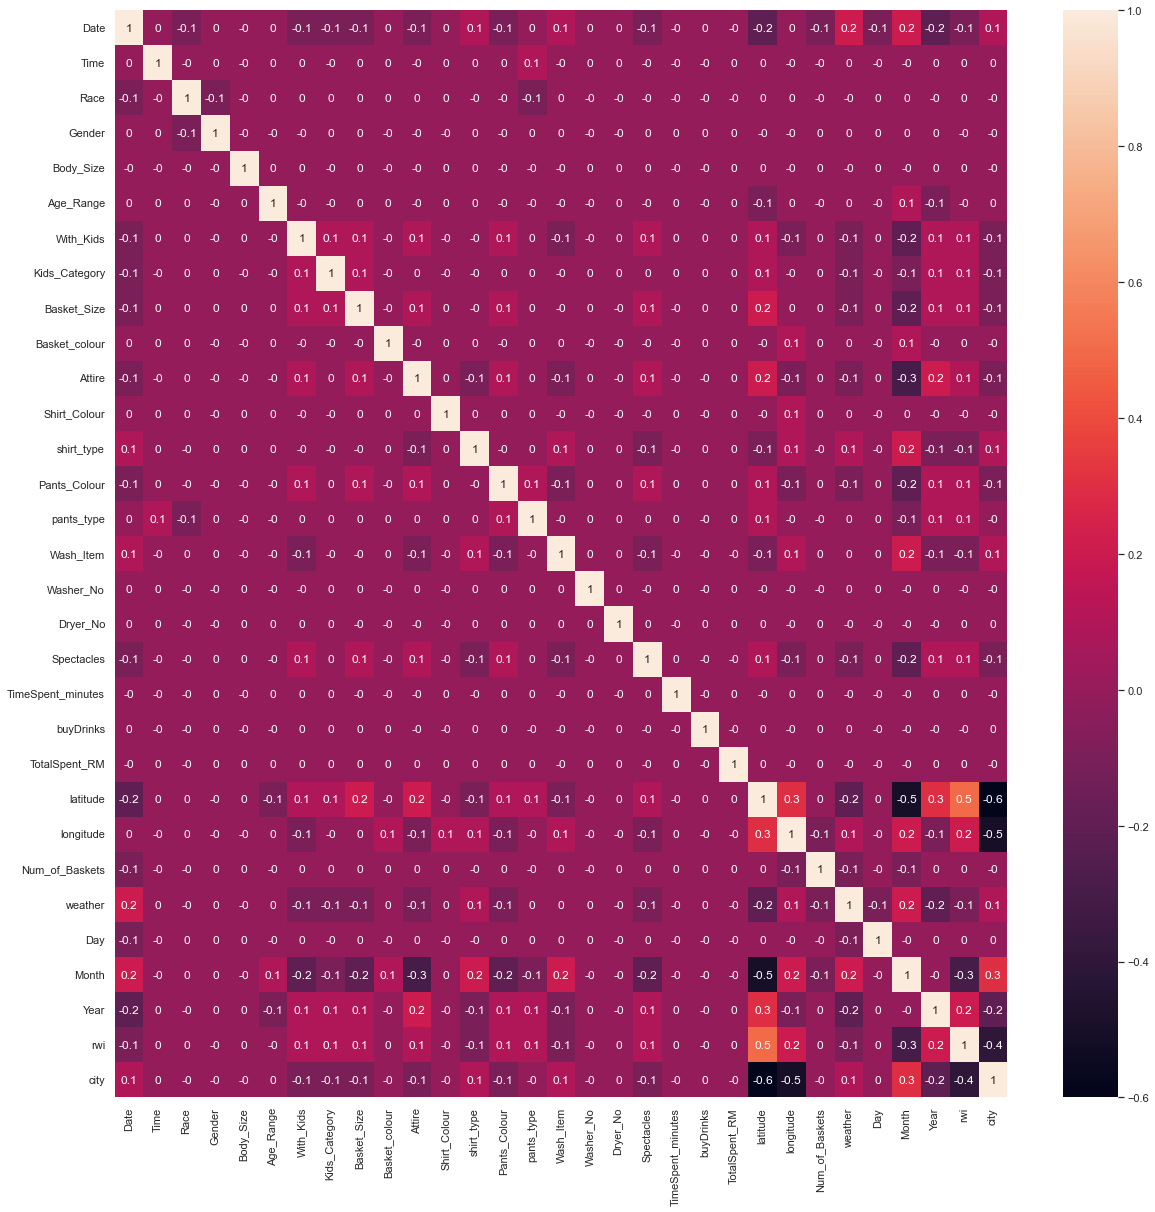

In [11]:
# heatmap
# plt.figure(figsize=(10,10))
# corr_map = sns.heatmap(imp_df.corr(), annot=True, fmt='.1g', cmap='coolwarm')
# plt.show()
# fig = corr_map.get_figure()
# fig.savefig("Correlation.png") 

# plot heatmap to show the correlation
imp_df = imp_df.apply(LabelEncoder().fit_transform)
sns.set(rc={'figure.figsize':(20, 20)})
correlation_matrix = imp_df.iloc[:,:].corr().round(1)
sns.heatmap(data=correlation_matrix, annot=True)

In [21]:
plt.style.use('fivethirtyeight')

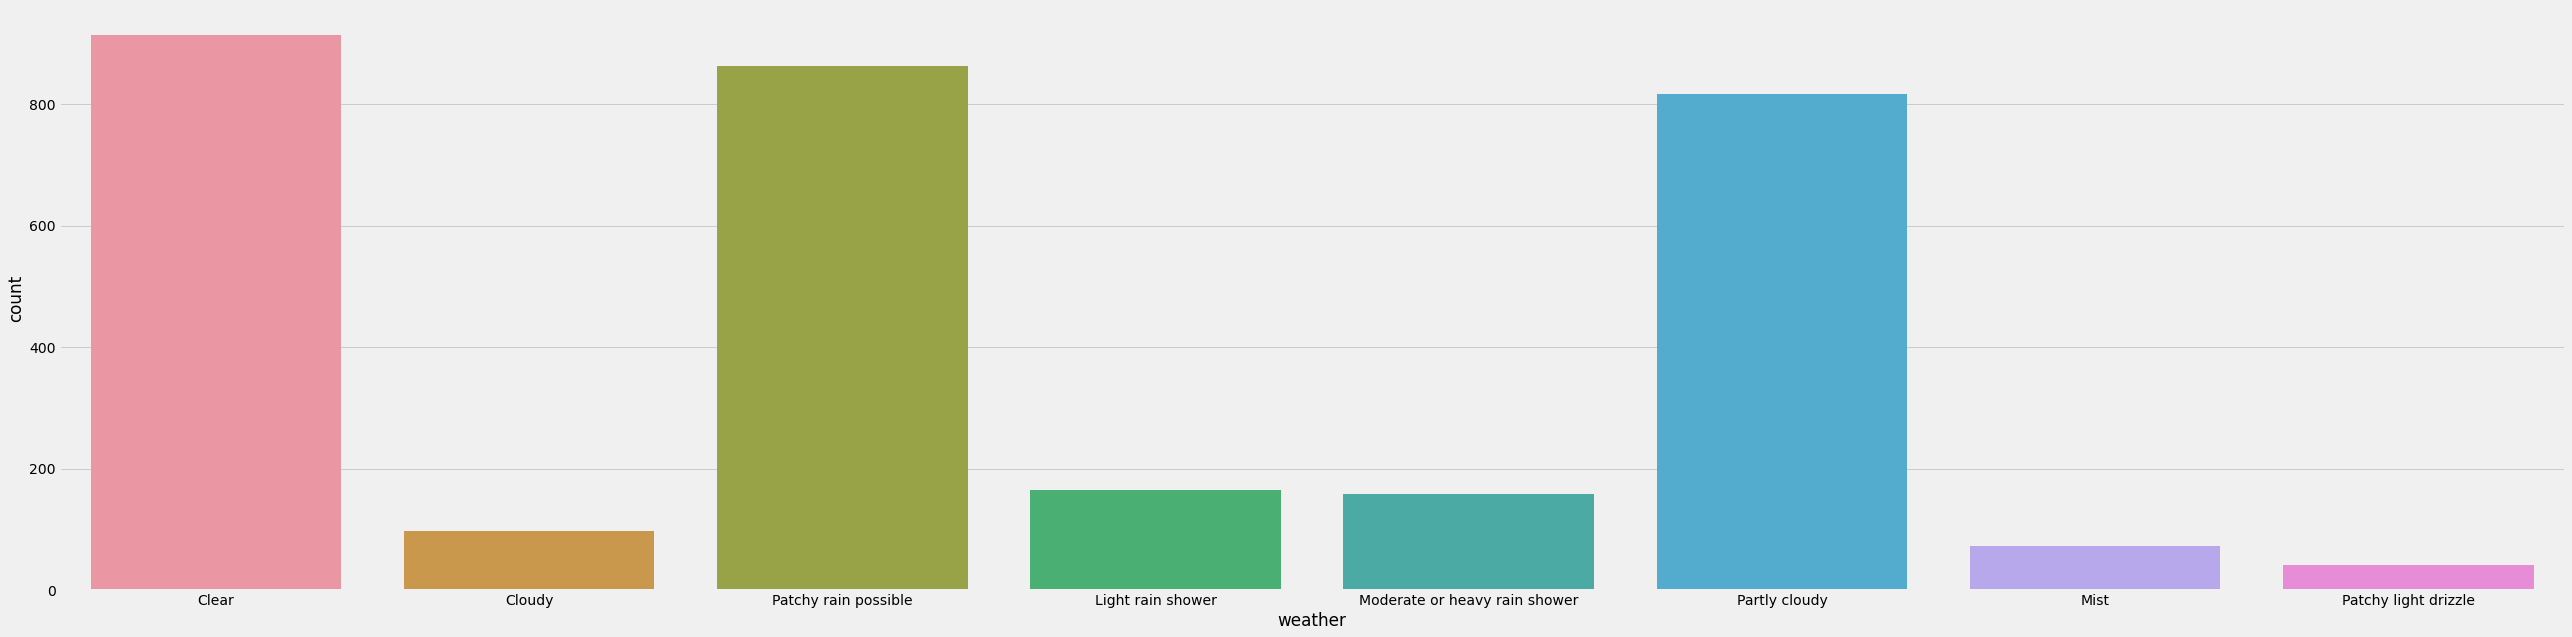

In [22]:
# see distirbution of weather
plt.figure(figsize=(40,10))
sns.countplot(x='weather', data=imp_df)
plt.show()

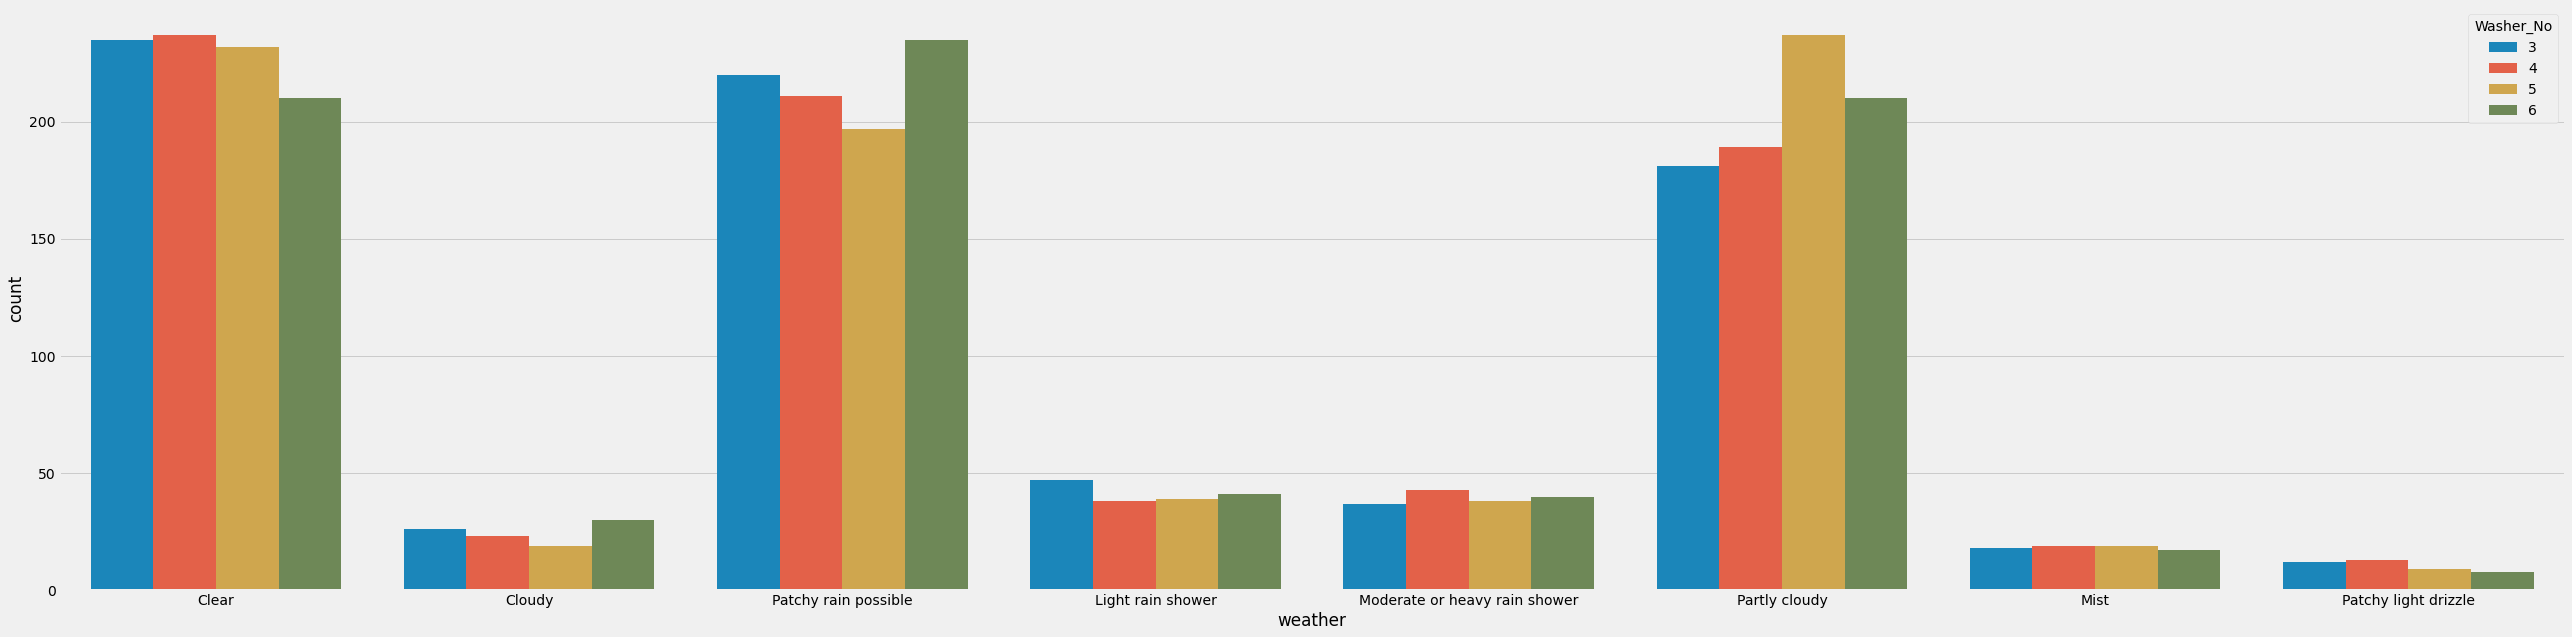

In [23]:
# plot relationship between weather and washer no
plt.figure(figsize=(40,10))
sns.countplot(x='weather', hue='Washer_No', data=imp_df)
plt.show()

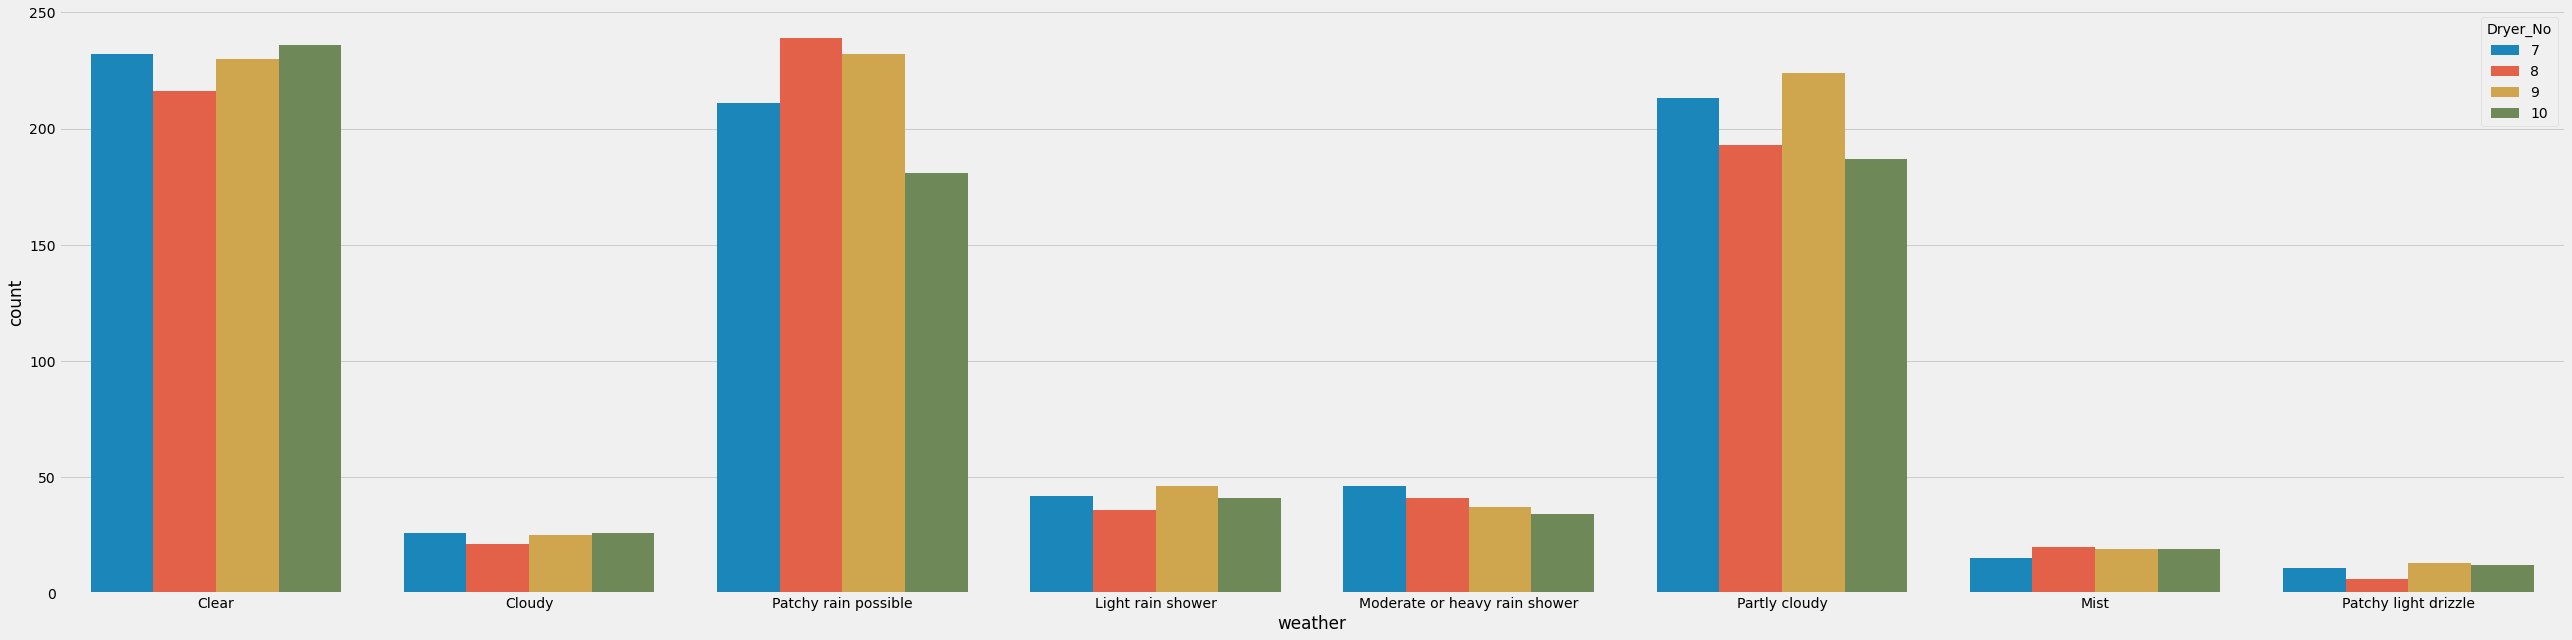

In [24]:
# plot relationship between weather and dryer no
plt.figure(figsize=(40,10))
sns.countplot(x='weather', hue='Dryer_No', data=imp_df)
plt.show()

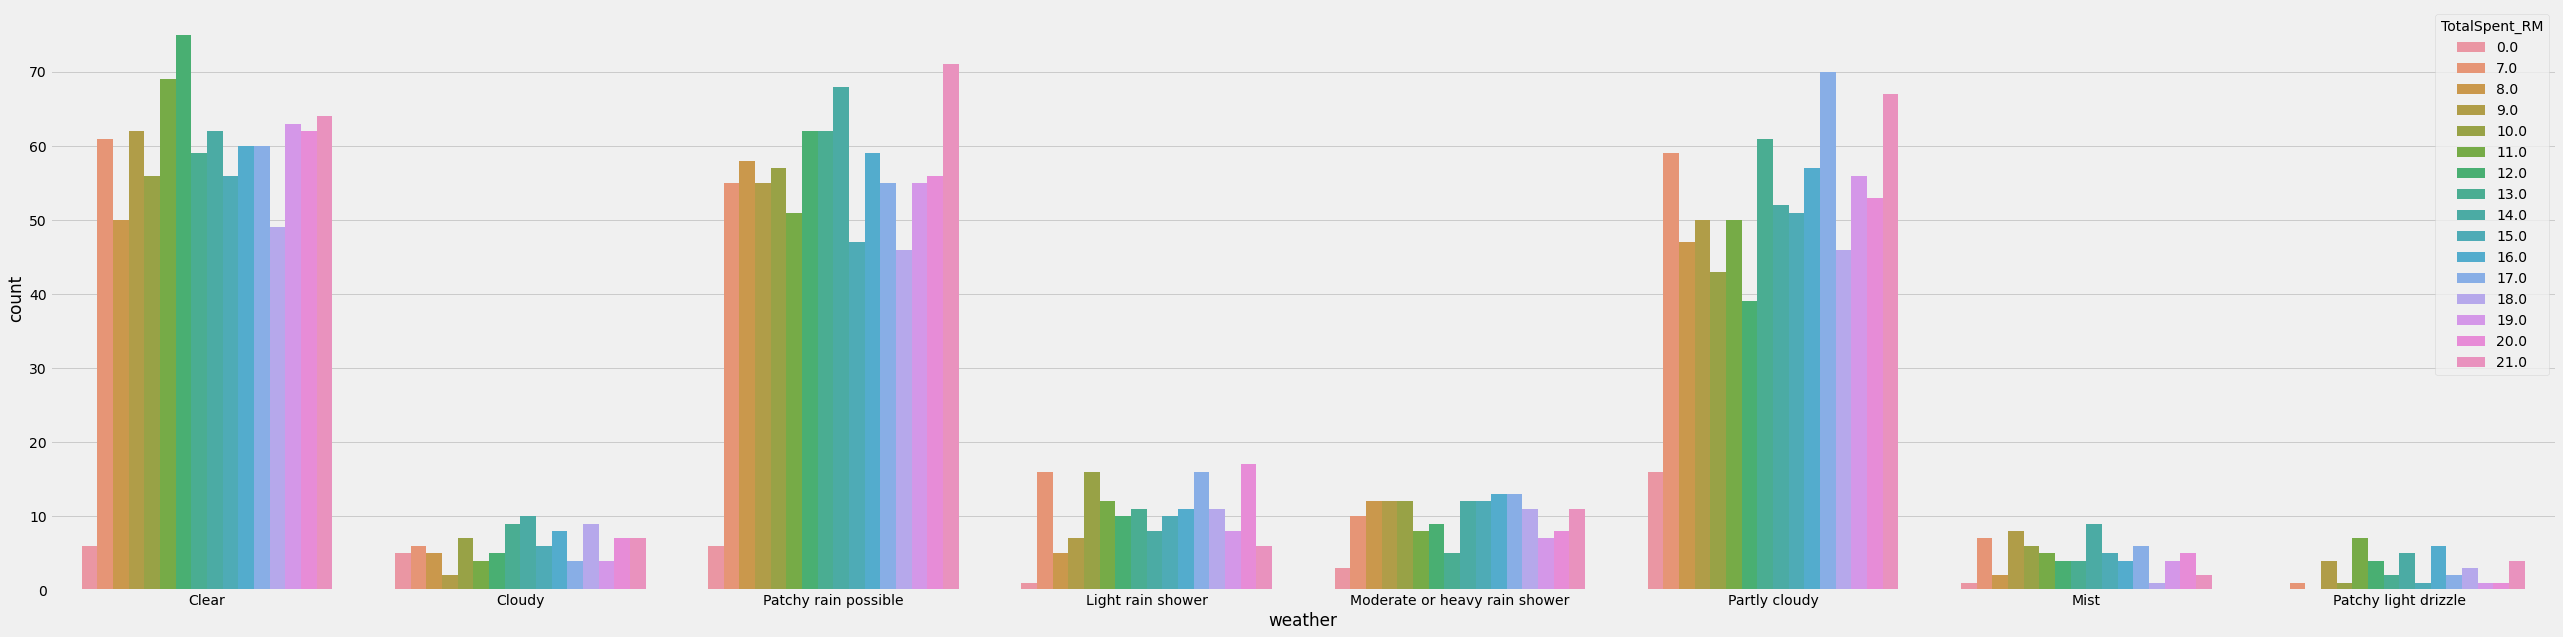

In [25]:
# plot relationship between weather and total spent
plt.figure(figsize=(40,10))
sns.countplot(x='weather', hue='TotalSpent_RM', data=imp_df)
plt.show()

/Users/shaun/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


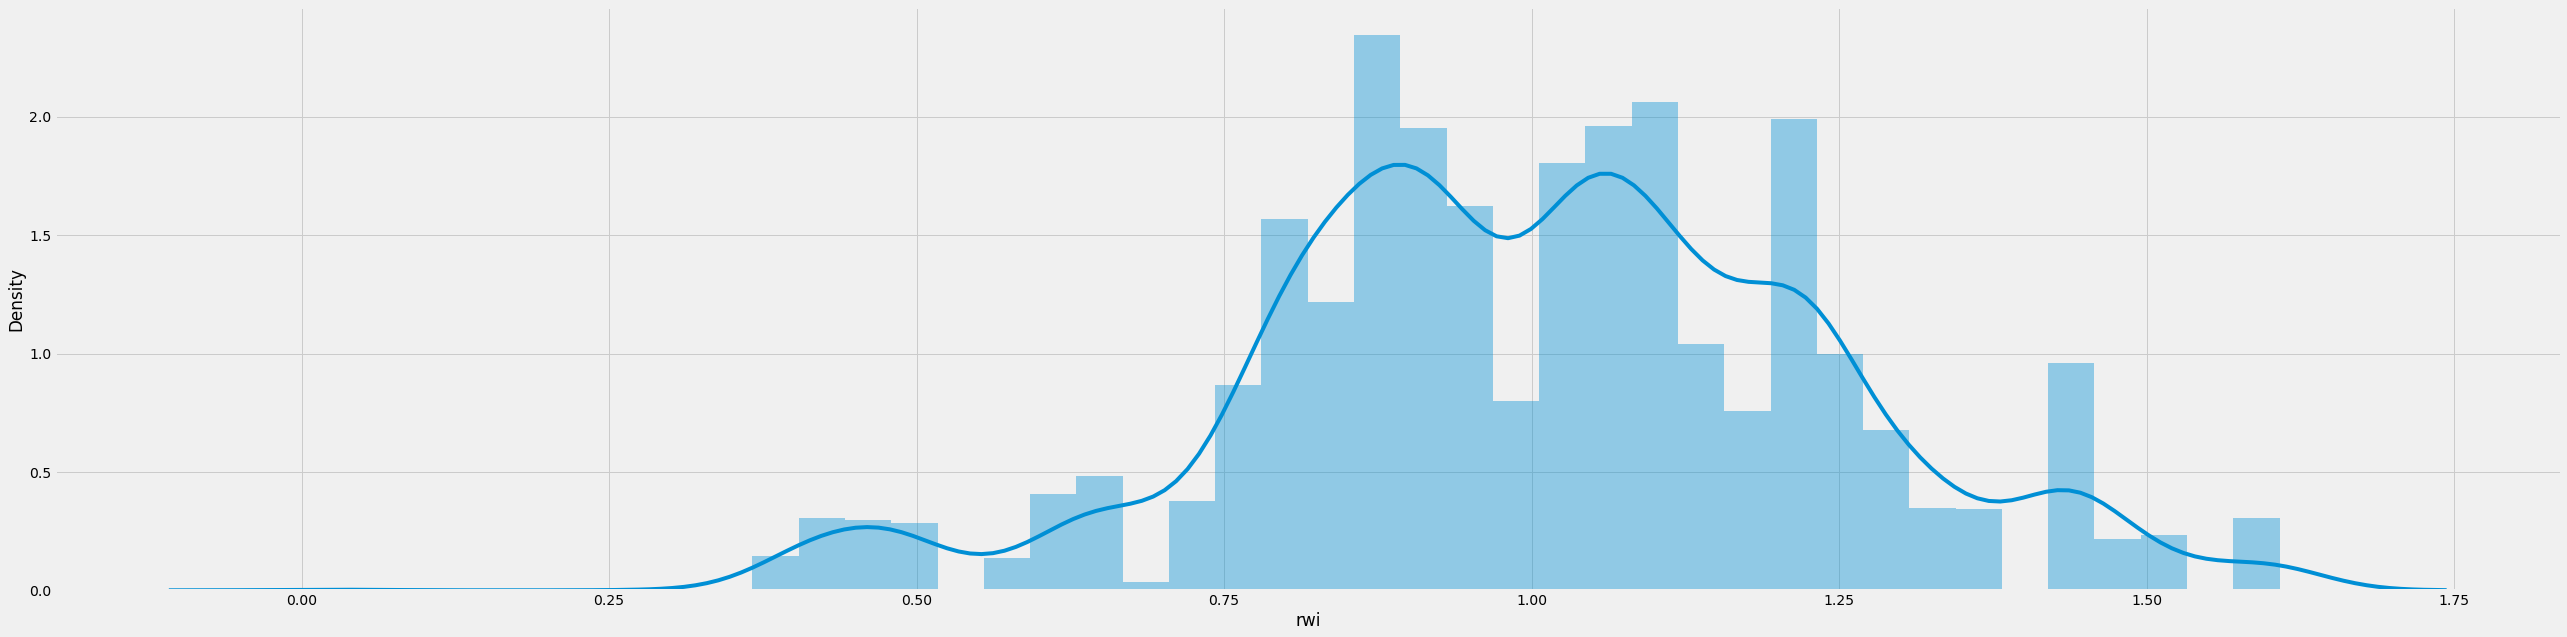

In [31]:
# plot distribution of rwi 
plt.figure(figsize=(40,10))
sns.distplot(imp_df['rwi'])
plt.show()

/Users/shaun/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


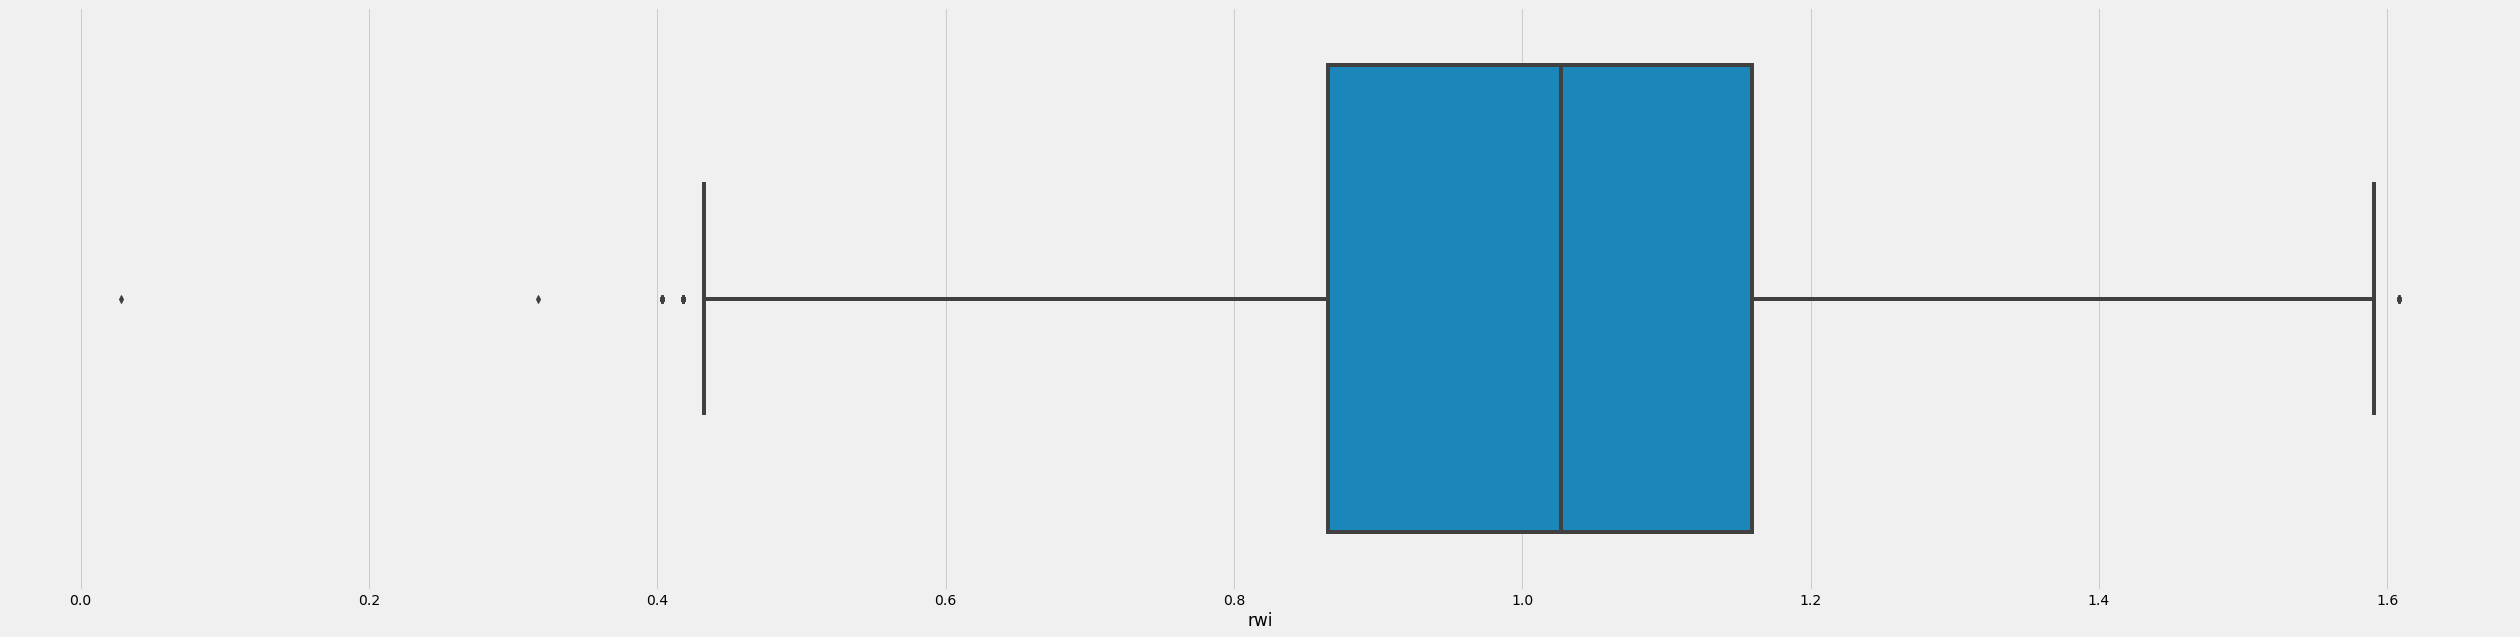

In [32]:
# plot boxplot for rwi
plt.figure(figsize=(40,10))
sns.boxplot(imp_df['rwi'])
plt.show()

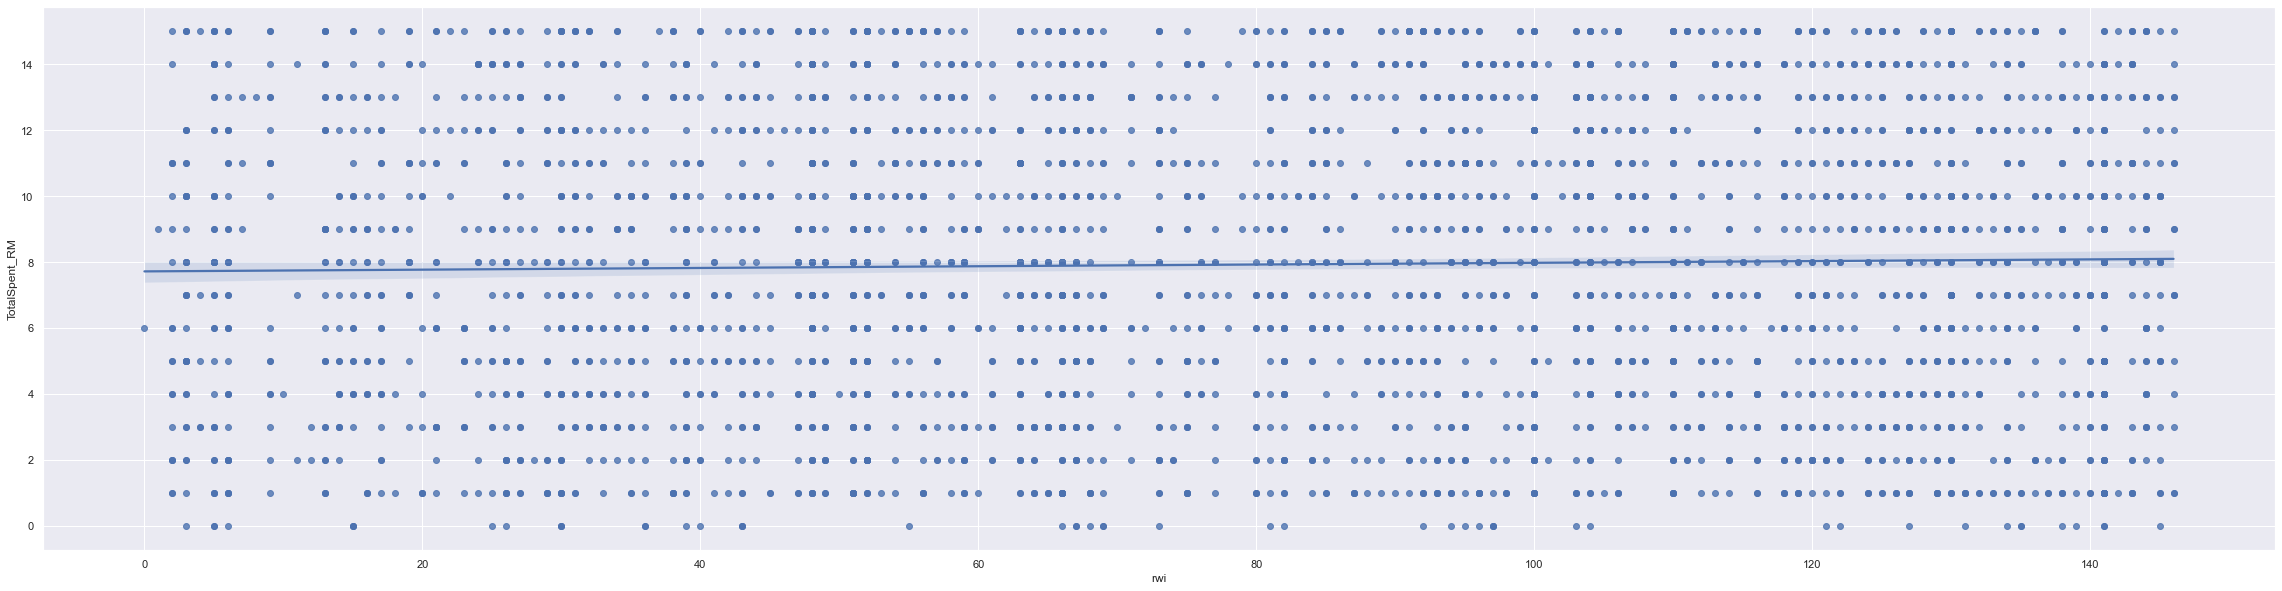

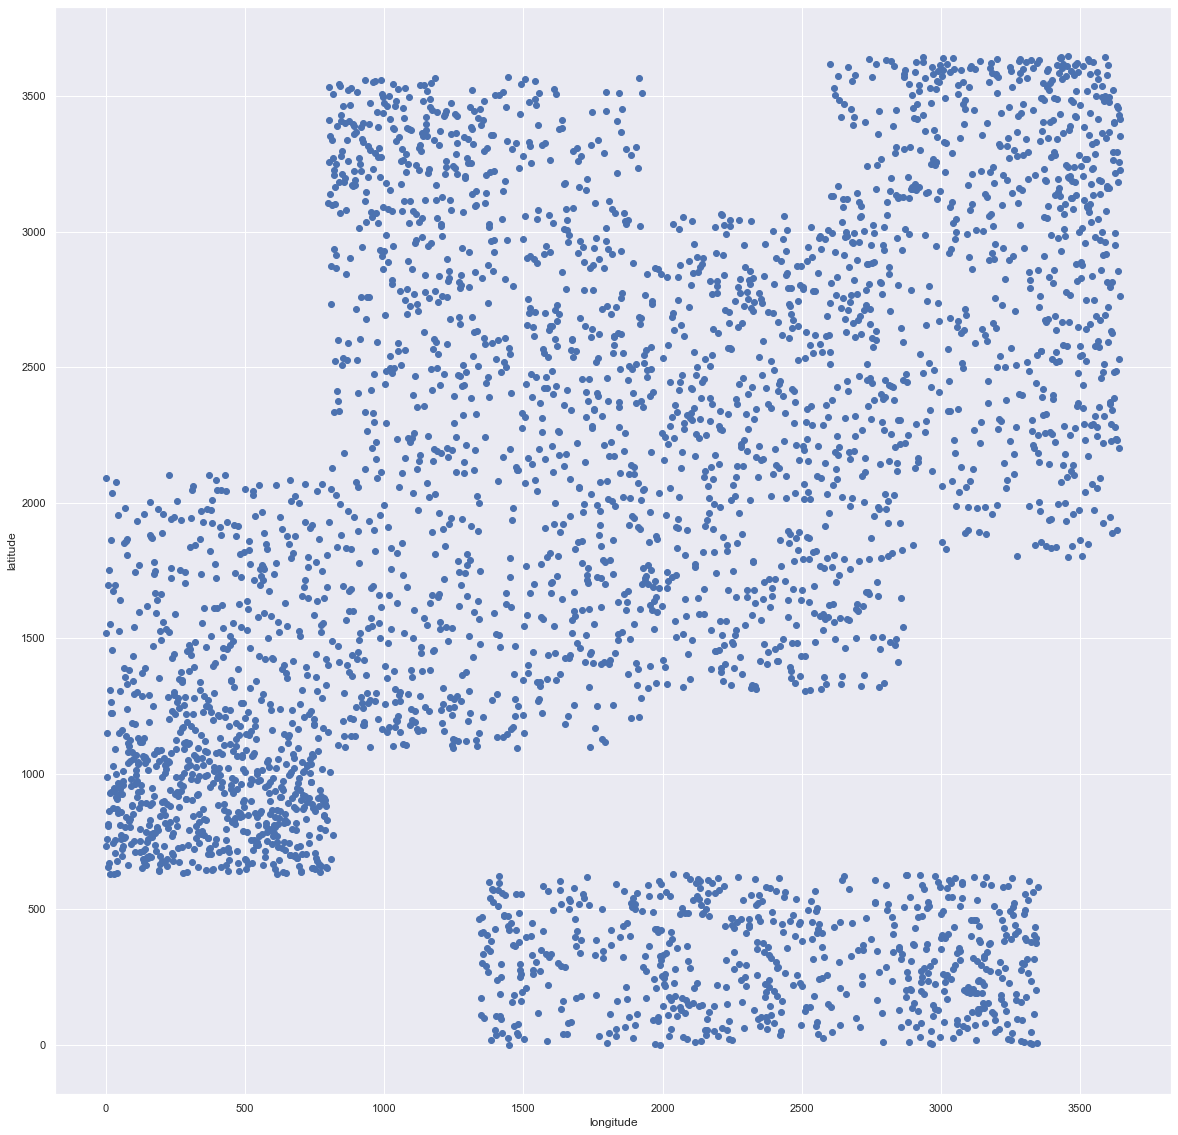

In [27]:
# plot relationship between rwi and total spent
plt.figure(figsize=(40,10))

sns.regplot(x='rwi', y='TotalSpent_RM', data=imp_df)
plt.show()

coordinate = plt.scatter(imp_df['longitude'],imp_df['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

<Figure size 2880x720 with 0 Axes>

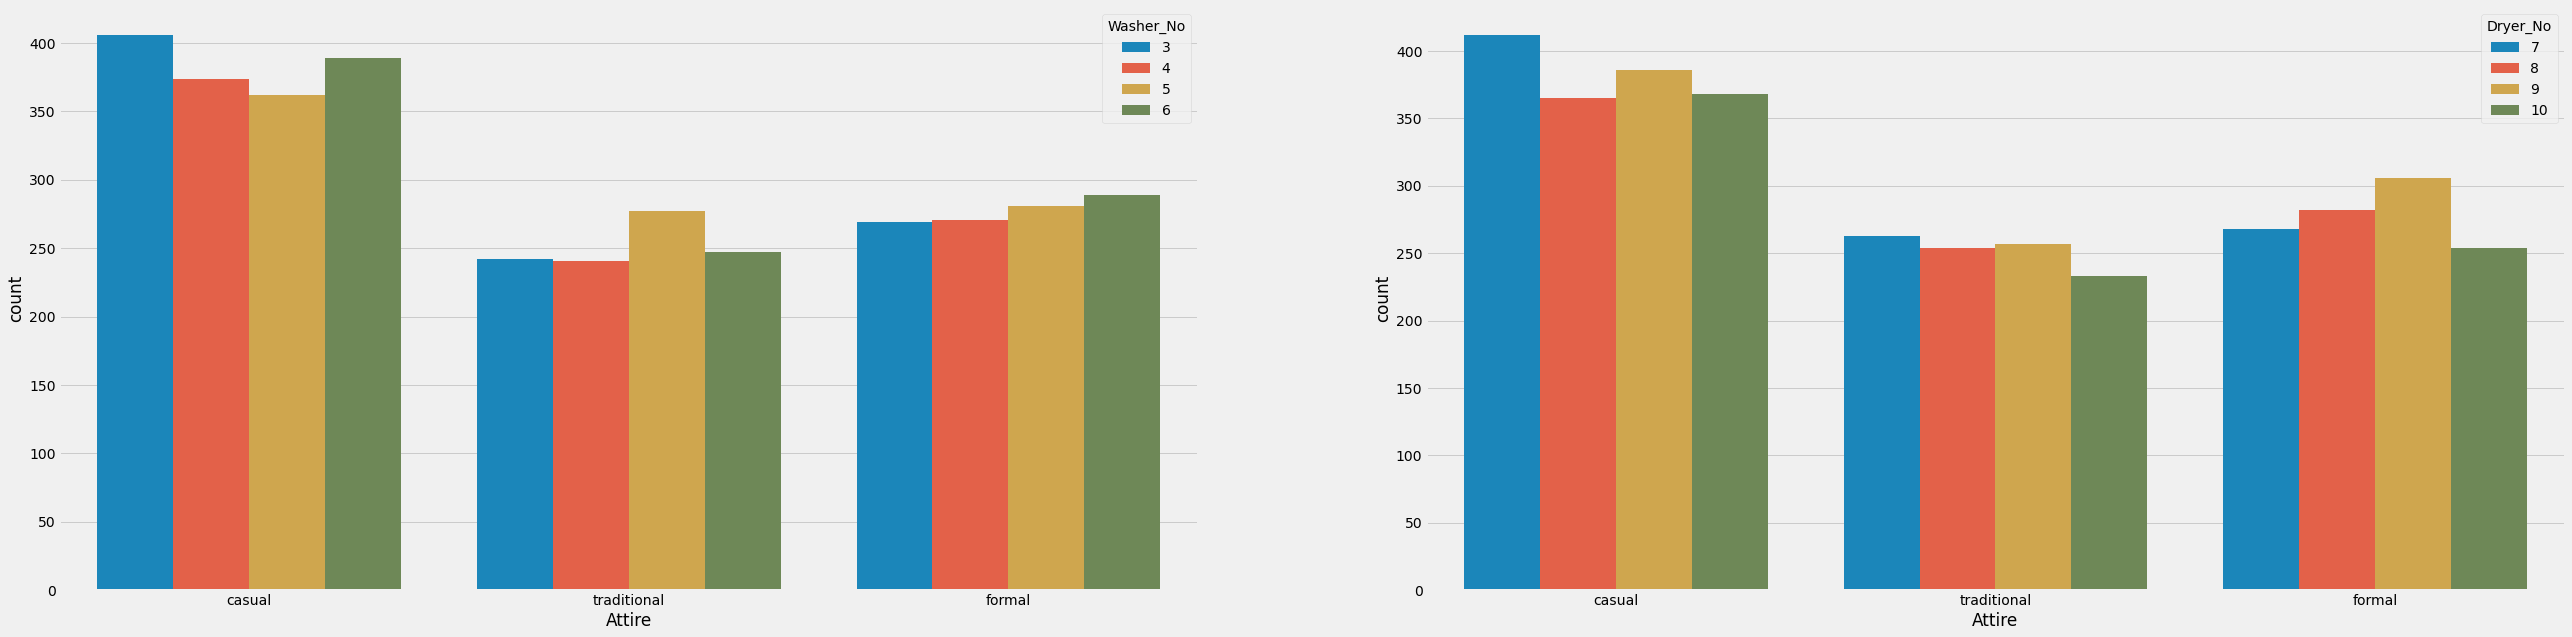

In [44]:
# plot relationship between attire and total spent
plt.figure(figsize=(40,10))

fig, ax = plt.subplots(1,2, figsize=(40,10))
sns.countplot(x='Attire', hue='Washer_No', data=imp_df, ax=ax[0])
sns.countplot(x='Attire', hue='Dryer_No', data=imp_df, ax=ax[1])
plt.show()

<Figure size 2880x720 with 0 Axes>

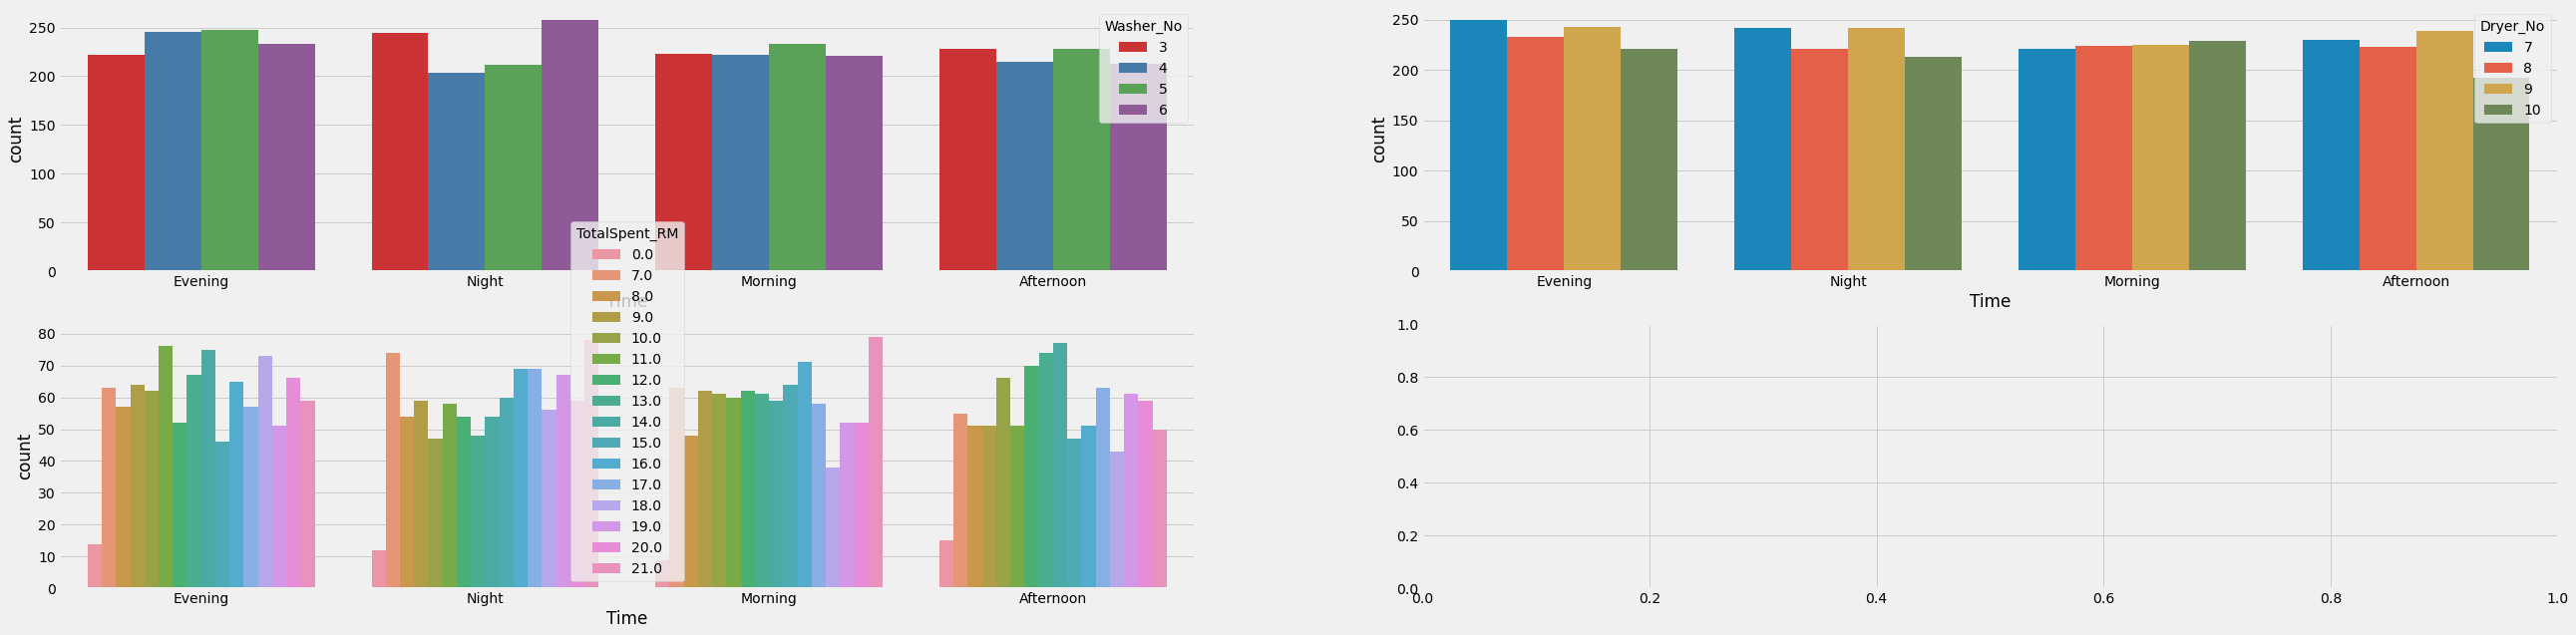

In [65]:
plt.figure(figsize=(40,10))

fig, ax = plt.subplots(2,2, figsize=(40,10))
sns.countplot(x='Time', hue='Washer_No', data=imp_df, ax=ax[0, 0], palette='Set1')
sns.countplot(x='Time', hue='Dryer_No', data=imp_df, ax=ax[0, 1])
sns.countplot(x='Time', hue='TotalSpent_RM', data=imp_df, ax=ax[1, 0])

plt.show()

<Figure size 7200x720 with 0 Axes>

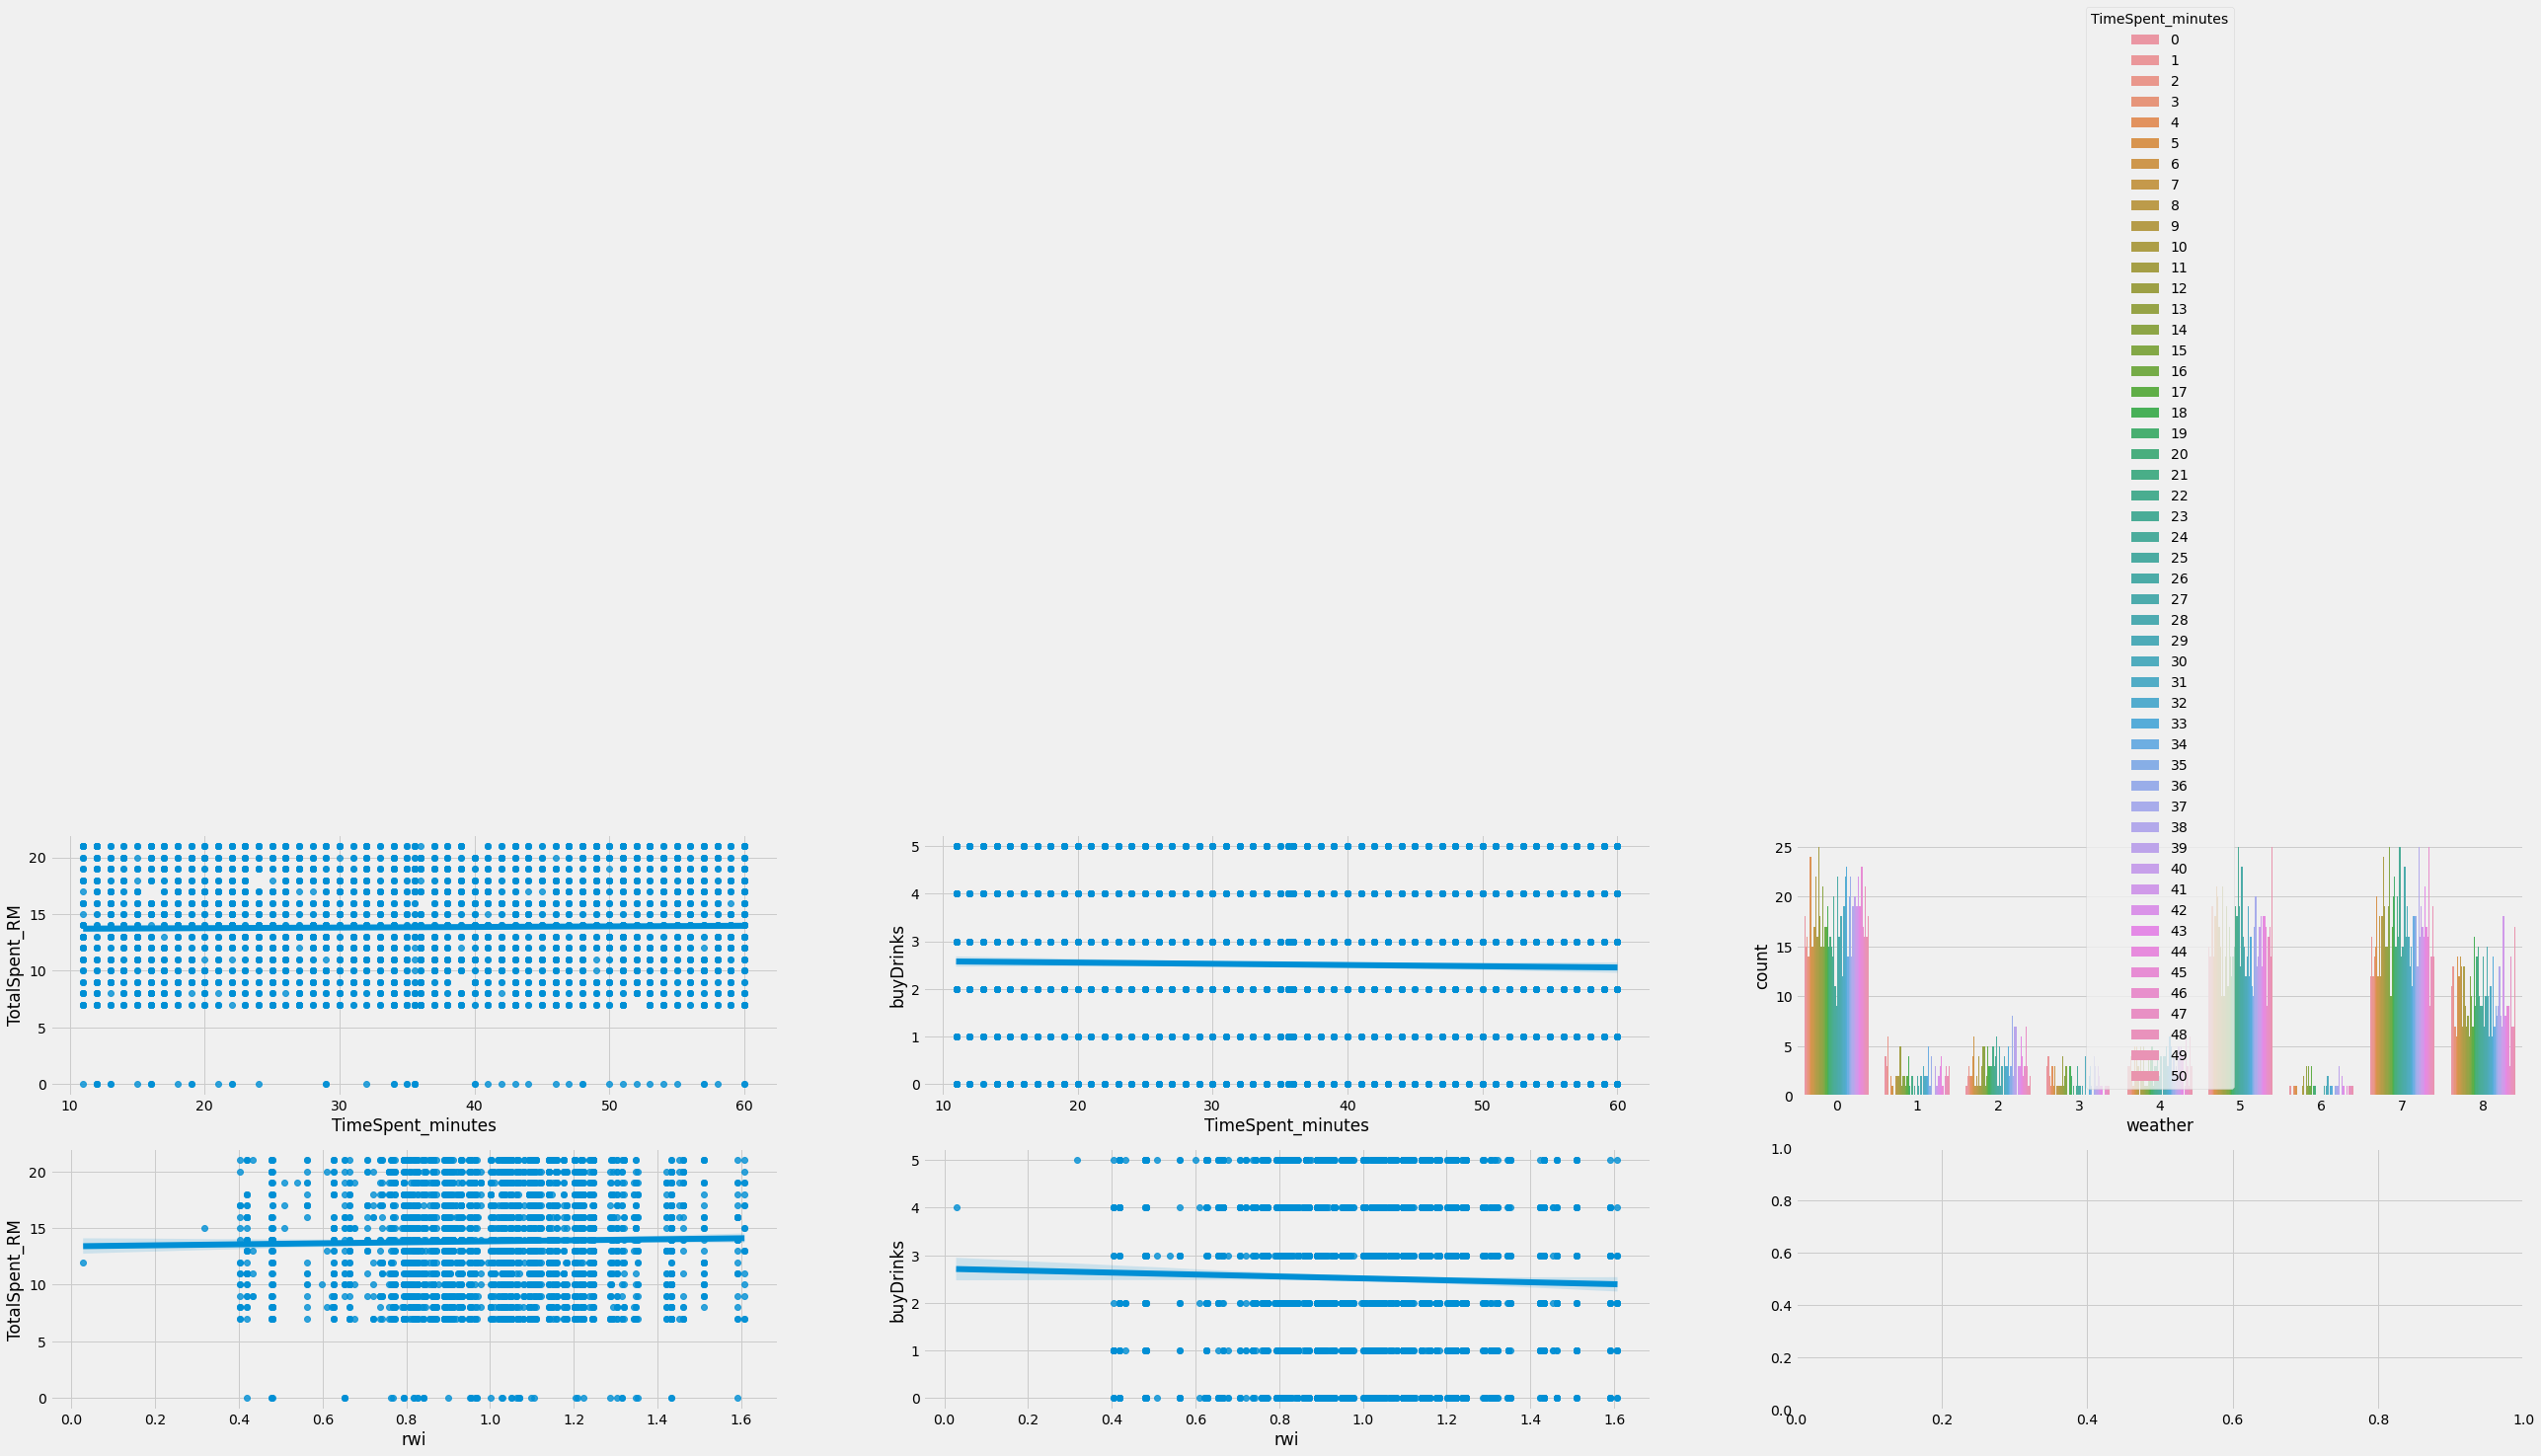

In [318]:
# relationship between time spent in minutes and total spent and buy drinks
plt.figure(figsize=(100,10))
fig, (ax1, ax2) = plt.subplots(2,3, figsize=(40,10))
sns.regplot(x='TimeSpent_minutes', y='TotalSpent_RM', data=imp_df, ax=ax1[0])
sns.regplot(x='TimeSpent_minutes', y='buyDrinks', data=imp_df, ax=ax1[1])
tsm_w = imp_df.apply(LabelEncoder().fit_transform)
sns.countplot(x='weather', hue='TimeSpent_minutes', data=tsm_w, ax=ax1[2])
sns.regplot(x='rwi', y='TotalSpent_RM', data=imp_df, ax=ax2[0])
sns.regplot(x='rwi', y='buyDrinks', data=imp_df, ax=ax2[1])

plt.show()

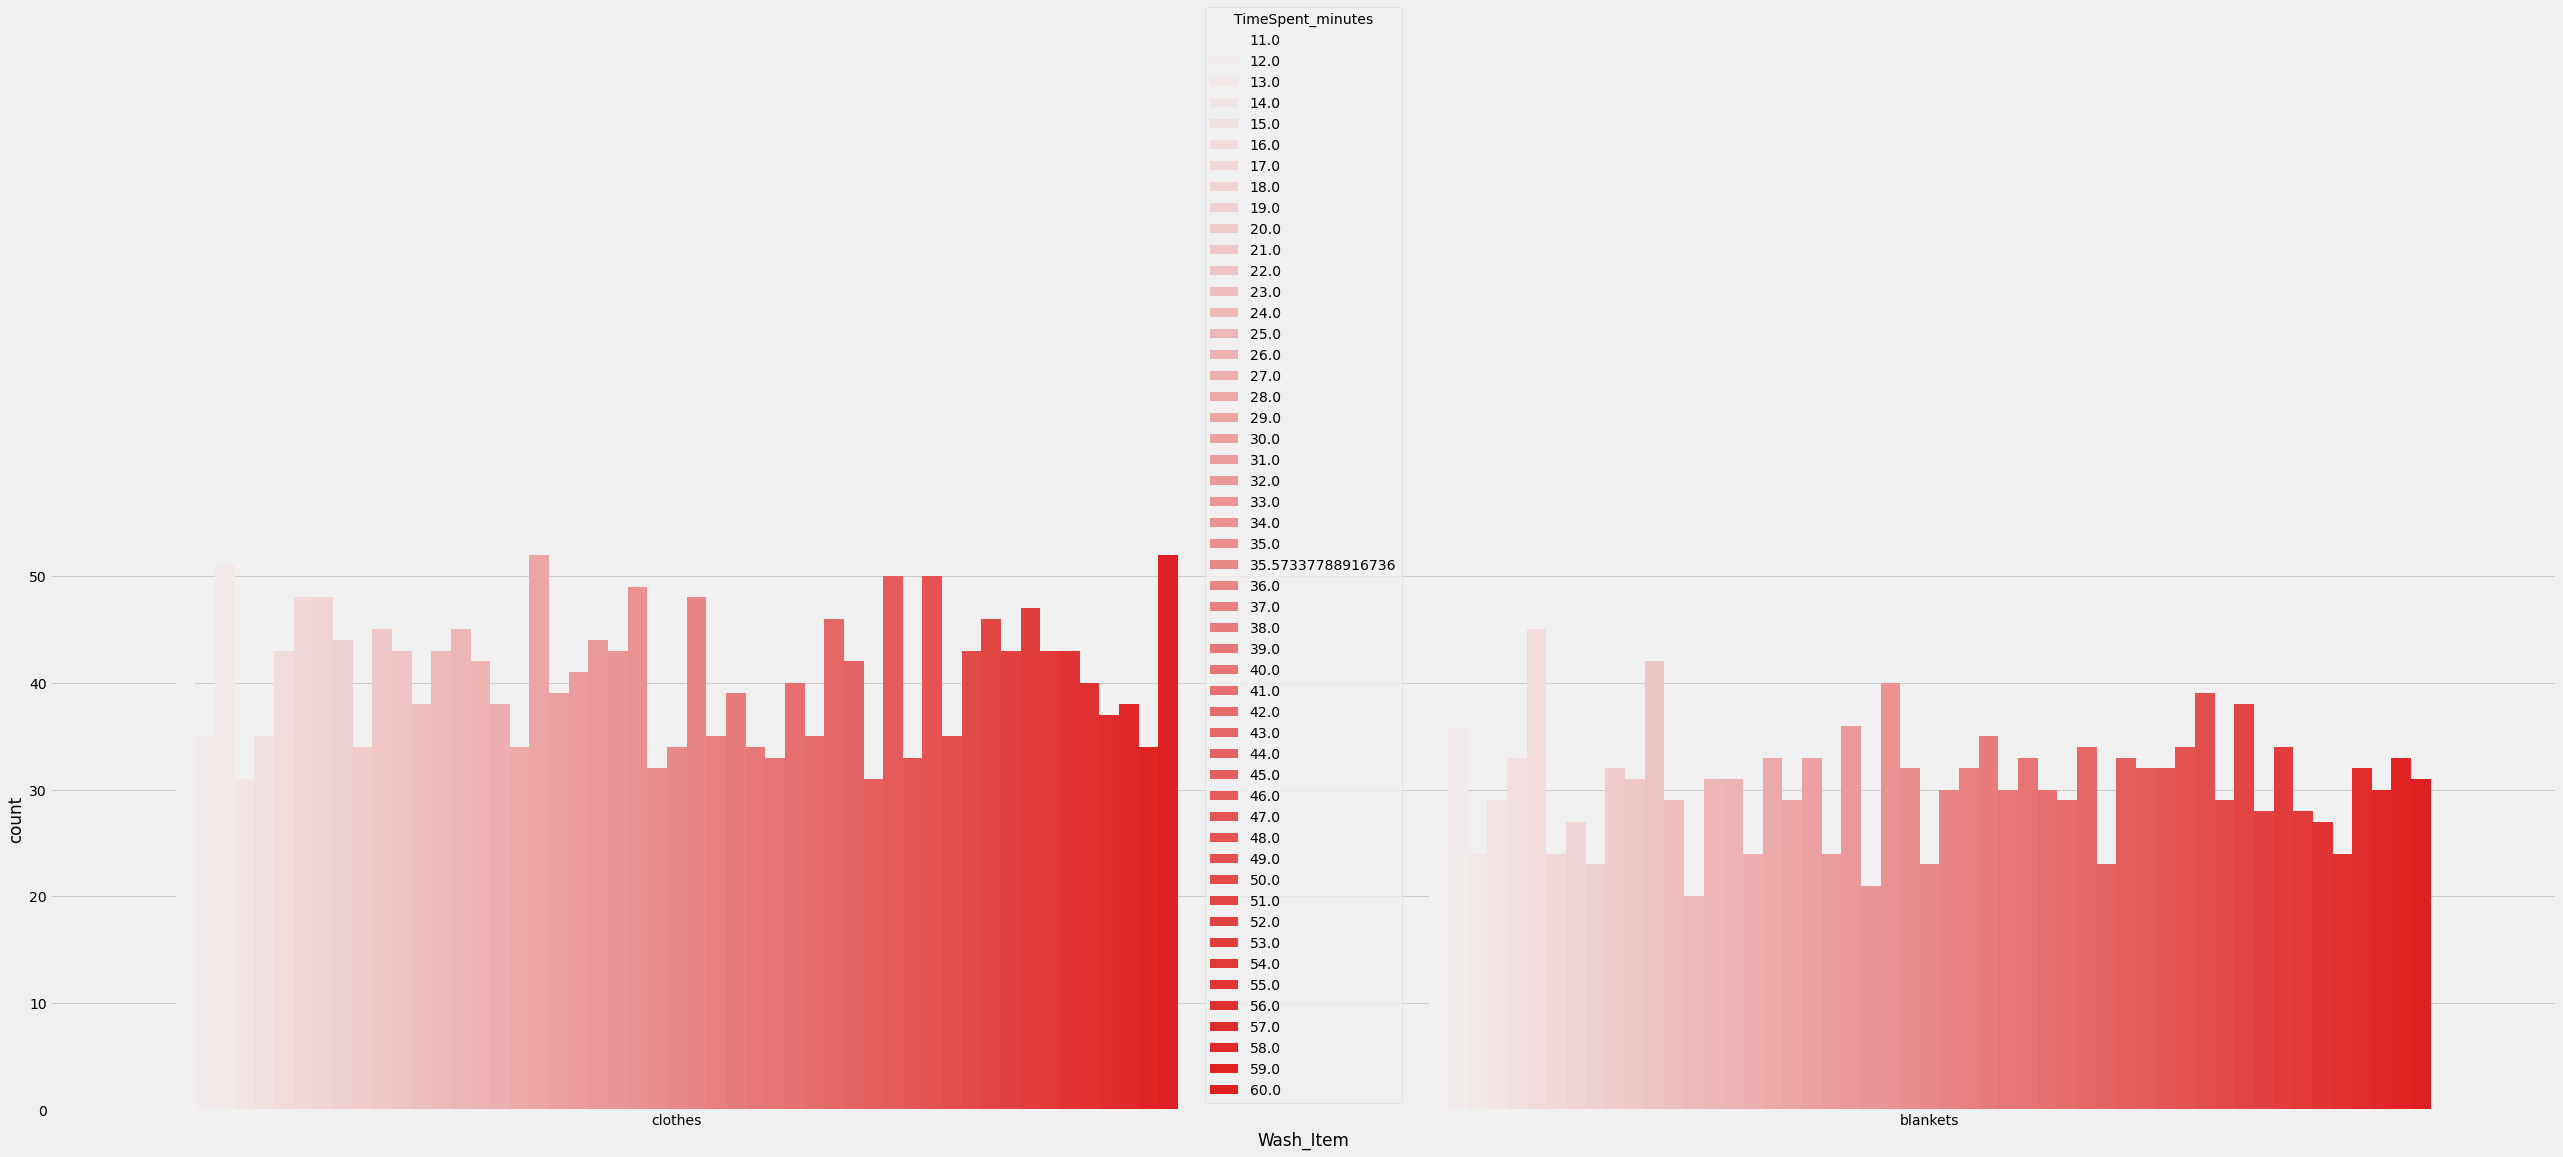

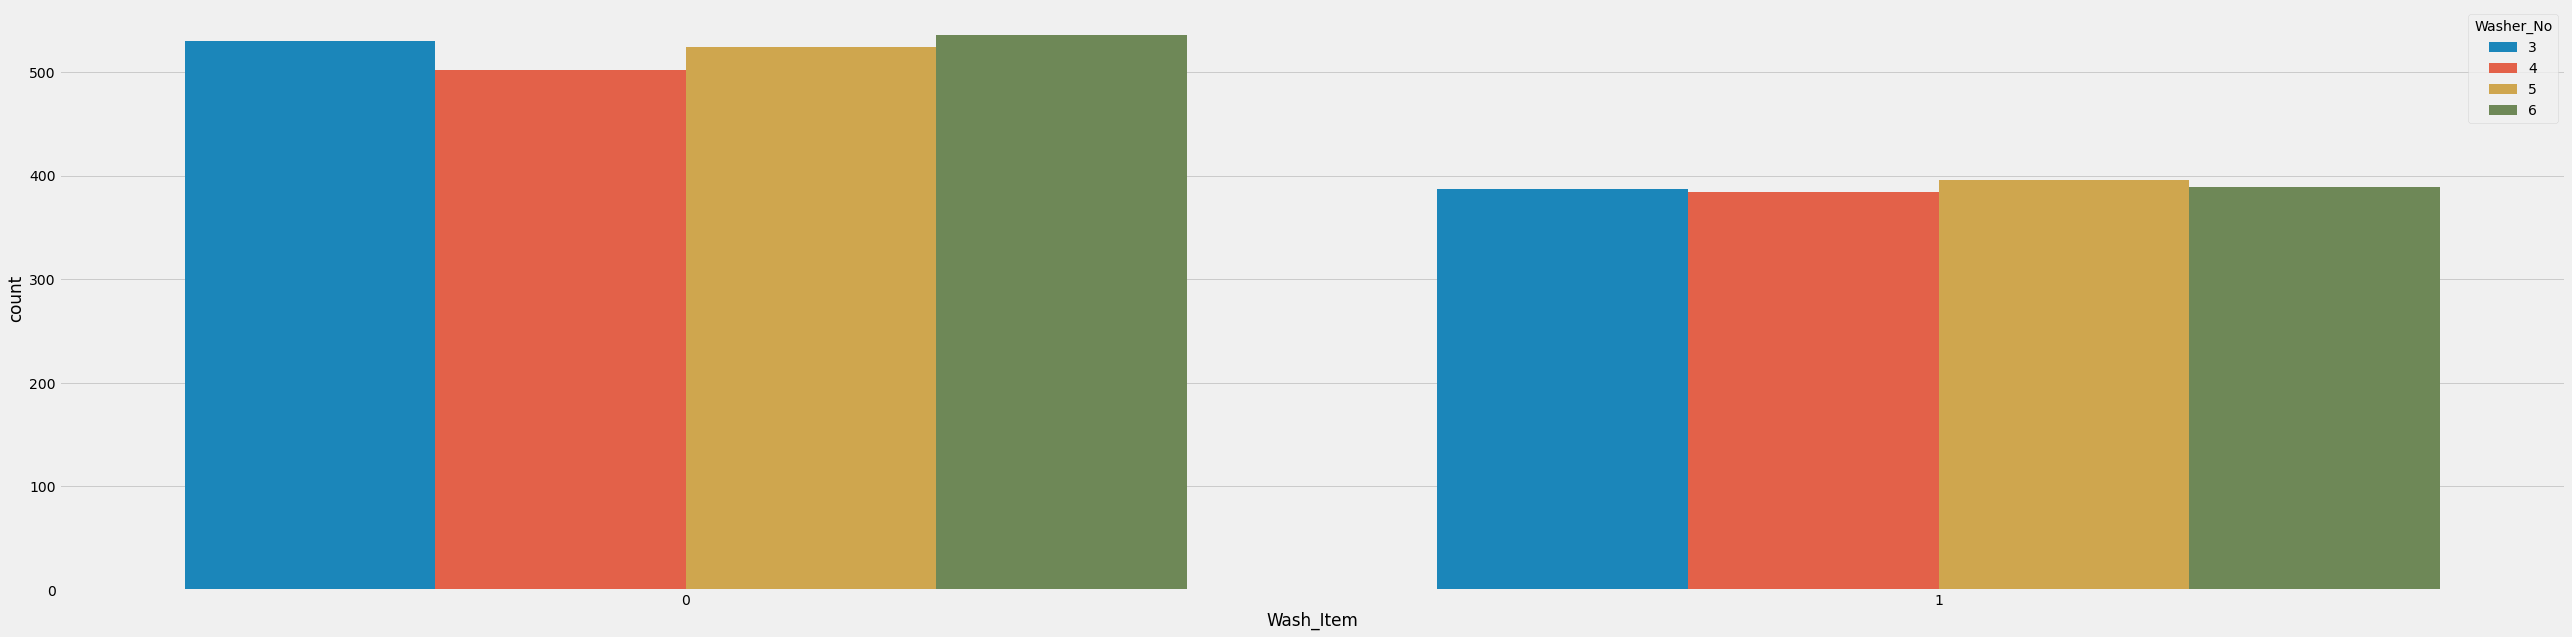

In [298]:
# plot relationship between time spent in minutes and wash item
plt.figure(figsize=(40,10))
sns.countplot(hue='TimeSpent_minutes', x='Wash_Item', data=imp_df, color="red")
plt.show()

plt.figure(figsize=(40,10))
# one hot encoding for wash item
# assign to 0, 1, 2, 3
wt_df = imp_df.copy()
wt_df['Wash_Item'] = wt_df['Wash_Item'].map({'clothes': 0, 'blankets': 1})
sns.countplot(x='Wash_Item', hue='Washer_No', data=wt_df)
plt.show()


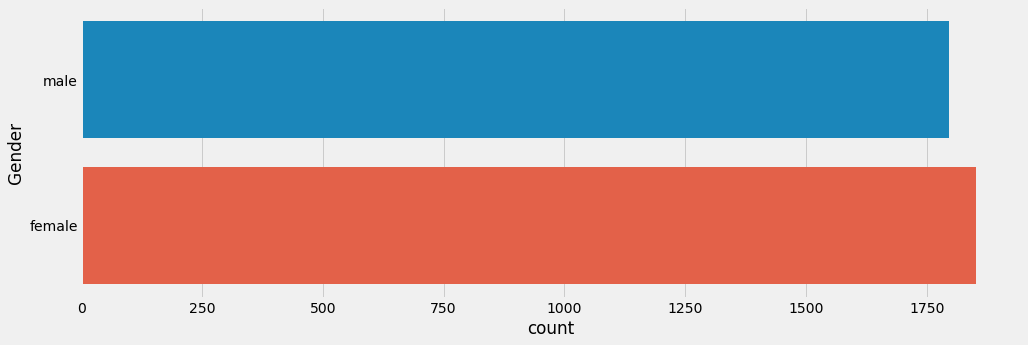

In [124]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = imp_df)
plt.show()

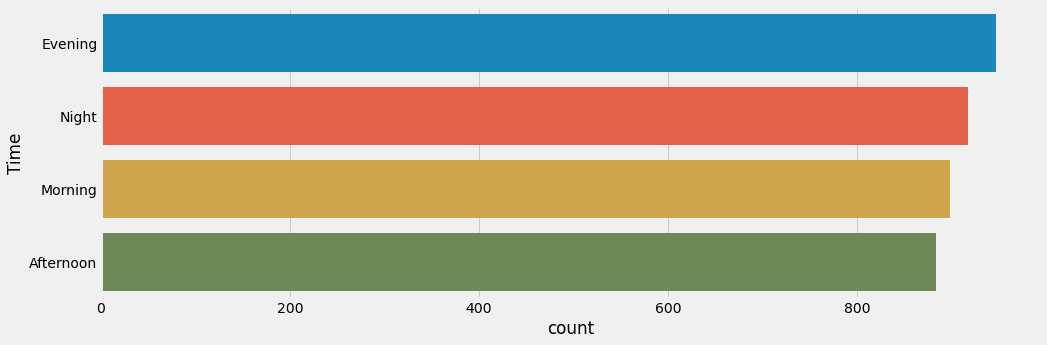

In [125]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Time' , data = imp_df)
plt.show()

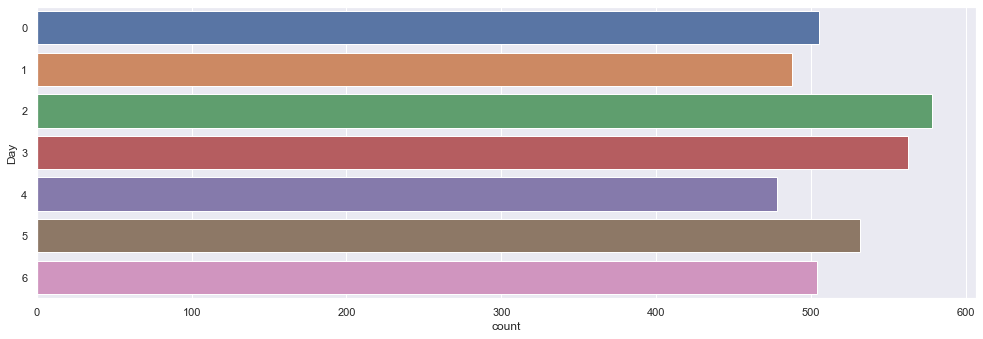

In [330]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Day' , data = imp_df)
plt.show()

/Users/shaun/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/shaun/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/shaun/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

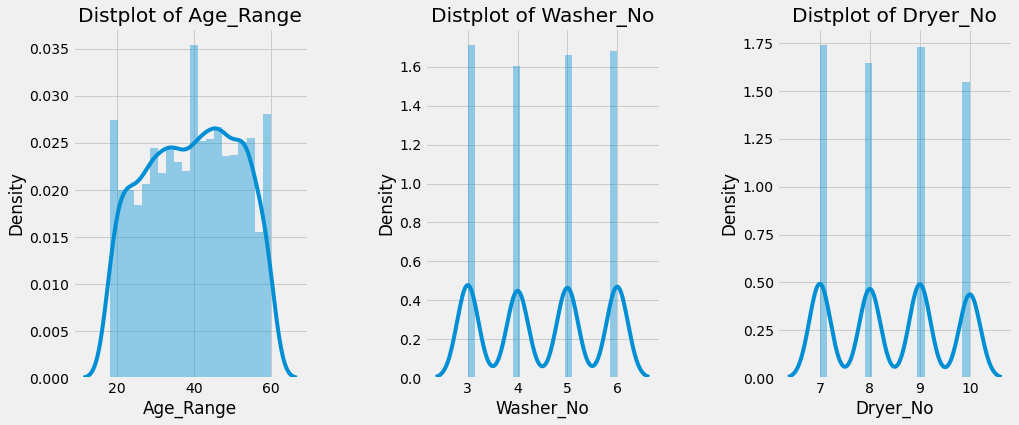

In [126]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in [ 'Age_Range', 'Washer_No', 'Dryer_No']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(dataframe[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

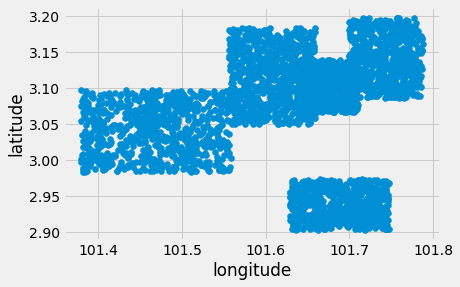

In [94]:
coordinate = plt.scatter(imp_df['longitude'],imp_df['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
coordinate.figure.savefig('Coordinate.png')
coordinate

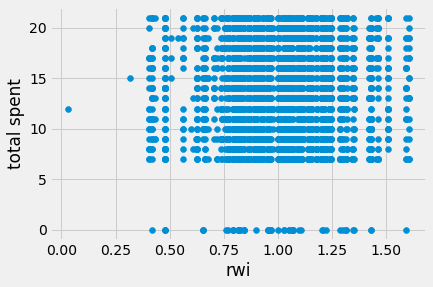

In [95]:
age_washer = plt.scatter(imp_df['rwi'],imp_df['TotalSpent_RM'])
plt.xlabel('rwi')
plt.ylabel('total spent')
age_washer.figure.savefig('rwi_spent.png')
age_washer

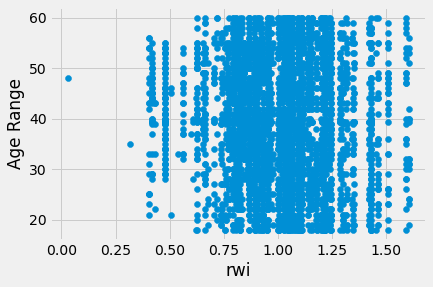

In [96]:
age_washer = plt.scatter(imp_df['rwi'],imp_df['Age_Range'])
plt.xlabel('rwi')
plt.ylabel('Age Range')
age_washer.figure.savefig('rwi_age.png')
age_washer

<AxesSubplot:xlabel='Time'>

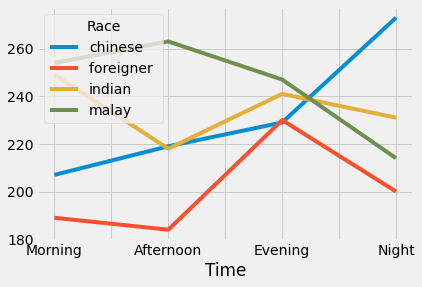

In [130]:
# reorder the time columns
imp_df['Time'] = pd.Categorical(imp_df['Time'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)
pd.crosstab(imp_df['Time'], imp_df['Race'] ).plot()

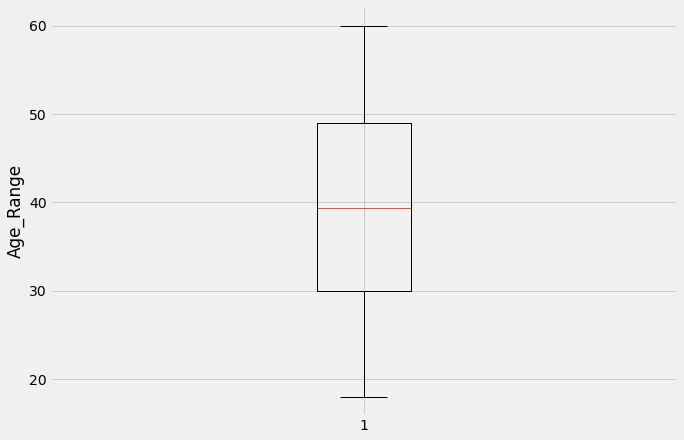

In [131]:
fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(imp_df['Age_Range'])

plt.ylabel('Age_Range')
# show plot
plt.show()

#### What types of customers will likely to choose Washer No.2 and Dryer No.3

In [1]:
sim = imp_df.copy()
display(sim)

display(sim['Washer_No'].value_counts())
display(sim['Dryer_No'].value_counts())

f_1 = sim['Washer_No'] == 3
f_2 = sim['Dryer_No'] == 10
customers = sim[f_1 & f_2].iloc[:,2:16]

for column in customers.columns:
    print(column + ': ' + str(customers[column].max()))

NameError: name 'imp_df' is not defined

<AxesSubplot:ylabel='Frequency'>

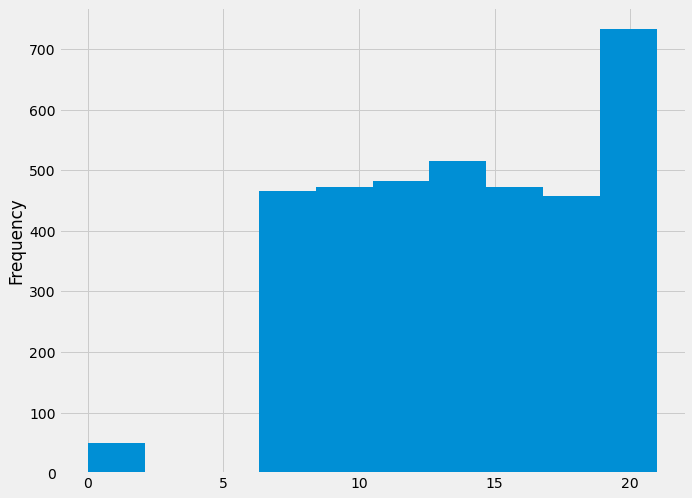

In [97]:
imp_df['TotalSpent_RM'].plot(kind="hist", figsize=(10,8))